Olena Ivina

# Homework #3[Master]. Behaviour exploration improvement

In [47]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 5]
import datetime as dt
import re
from matplotlib.ticker import MultipleLocator
import warnings
warnings.filterwarnings('ignore')

In [2]:
channels = os.listdir('CSS_TG_data_v1/channels/')

# the table 'rybar.csv' has no data channel.shape = (0, 1), so I removed this channel from the analysis
channels = [el for el in channels if el != 'rybar.csv'] 
print(len(channels))
channels[0:3]

299


['Doninside.csv', 'SergeyKolyasnikov.csv', 'warfakes.csv']

# Dataset

### Number of messages

In [4]:
messages_num = 0
for channel_name in tqdm(channels):
    channel = pd.read_csv(f'CSS_TG_data_v1/channels/{channel_name}', low_memory=False)
    messages_num += channel.shape[0]
    
print(messages_num)

100%|█████████████████████████████████████████| 299/299 [01:00<00:00,  4.96it/s]

8108693


In [10]:
varlamov = pd.read_csv(f'CSS_TG_data_v1/channels/varlamov.csv', low_memory=False)
varlamov.head()

Unnamed: 0    id                       date     views  \
0           0  8039  2022-12-19 08:08:36+00:00   50274.0   
1           1  8038  2022-12-18 15:06:29+00:00  105387.0   
2           2  8037  2022-12-18 15:03:02+00:00   82309.0   
3           3  8036  2022-12-18 13:49:14+00:00  384514.0   
4           4  8034  2022-12-18 13:16:21+00:00   81747.0   

                                           reactions  \
0  MessageReactions(results=[ReactionCount(reacti...   
1  MessageReactions(results=[ReactionCount(reacti...   
2  MessageReactions(results=[ReactionCount(reacti...   
3  MessageReactions(results=[ReactionCount(reacti...   
4  MessageReactions(results=[ReactionCount(reacti...   

                                to_id fwd_from  \
0  PeerChannel(channel_id=1005684212)      NaN   
1  PeerChannel(channel_id=1005684212)      NaN   
2  PeerChannel(channel_id=1005684212)      NaN   
3  PeerChannel(channel_id=1005684212)      NaN   
4  PeerChannel(channel_id=1005684212)      NaN   

                                             message     type  duration  
0  Читаю у пропагандистов, что Аргентина победила...     text       NaN  
1  Вообще, народ что-то перестал ценить z-творчес...    photo       NaN  
2  Клип "Сарматушка" на слова Рогозина (про то ка...    video      28.0  
3  Путин хочет построить новый город в Херсонской...    photo       NaN  
4                                                  🎄  sticker       NaN

In [13]:
varlamov['message'].dropna().str.count(' ') + 1

0       28
1       32
2       43
3       56
4        1
        ..
7618     4
7619     2
7621     5
7622     1
7623     1
Name: message, Length: 5686, dtype: int64

### Distribution by message length

In [21]:
words_count = dict()
for channel_name in tqdm(channels):
    channel = pd.read_csv(f'CSS_TG_data_v1/channels/{channel_name}', low_memory=False)
    channel = channel.dropna(subset=['message'])
    channel['words_count'] = channel['message'].str.count(' ') + 1
    for el in channel['words_count'].tolist():
        if el not in words_count.keys():
            words_count[el] = 1
        else:
            words_count[el] += 1

100%|█████████████████████████████████████████| 299/299 [01:12<00:00,  4.12it/s]


In [15]:
print(len(words_count.keys()))

1190


In [19]:
list(words_count.keys())[0:3]

[57, 73, 64]

In [22]:
words_count[64]

30365

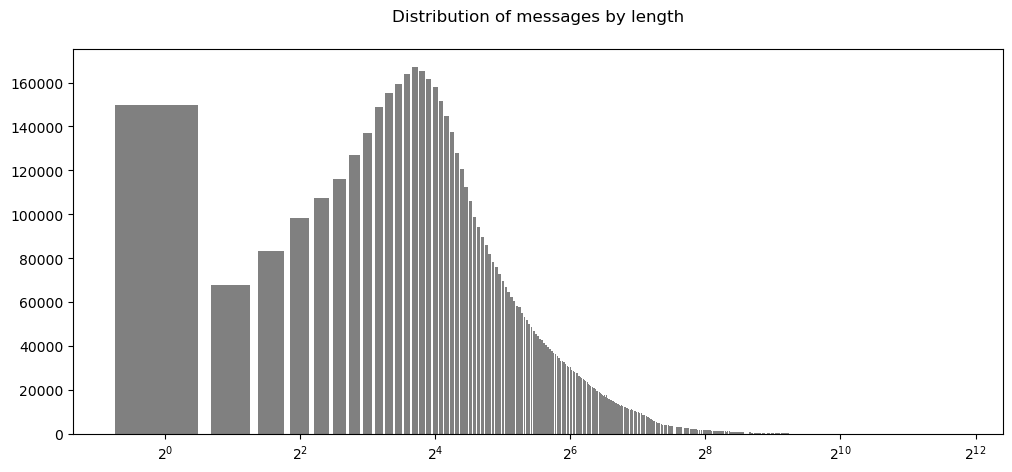

In [25]:
plt.rcParams["figure.figsize"] = [12, 5]
plt.bar(list(words_count.keys()), words_count.values(), color='grey')
plt.title('Distribution of messages by length',y=1.05)
plt.xscale('log',base=2) 
plt.show()

In [28]:
np.max(list(words_count.keys()))

3517

In [29]:
to_count_avarage_l = []
for key, value in words_count.items():
    for i in range(value):
        to_count_avarage_l.append(key)
        
len(to_count_avarage_l)

7016265

In [30]:
np.mean(to_count_avarage_l)

55.26409663831112

In [31]:
from scipy import stats
stats.mode(to_count_avarage_l)

ModeResult(mode=13, count=167105)

# Number of days covered by Telegram channels

In [3]:
channels_min_max_dates = dict()
for channel_name in tqdm(channels):
    channel = pd.read_csv(f'CSS_TG_data_v1/channels/{channel_name}', low_memory=False)
    if channel.shape[0] > 0:
        channel['date_time'] = pd.to_datetime(channel['date'])
        channels_min_max_dates[channel_name] = (channel['date_time'].min(), channel['date_time'].max())
start_end_df = pd.DataFrame.from_dict(channels_min_max_dates, orient='index', columns=['From', 'To']).reset_index().rename(columns={"index": "Channel"}).sort_values(by=['From'])
start_end_df.head(3)

100%|█████████████████████████████████████████| 299/299 [01:17<00:00,  3.88it/s]


Channel                      From                        To
271   moscowmap.csv 2015-09-22 11:53:32+00:00 2022-12-19 10:05:07+00:00
286    varlamov.csv 2015-09-22 14:46:48+00:00 2022-12-19 08:08:36+00:00
215  otsuka_bld.csv 2015-09-22 21:17:51+00:00 2022-12-26 06:09:06+00:00

In [4]:
start_end_df.From.min()

Timestamp('2015-09-22 11:53:32+0000', tz='UTC')

In [5]:
start_end_df.From.max()

Timestamp('2022-09-23 09:07:39+0000', tz='UTC')

### Top 15 oldest channels in the dataset

In [4]:
# project start date
proj_start = start_end_df.From.min()

# number of days from project start to task start
start_end_df['start_num'] = (start_end_df.From-proj_start).dt.days

# number of days from project start to end of tasks
start_end_df['end_num'] = (start_end_df.To-proj_start).dt.days

# days between start and end of each task
start_end_df['days_start_to_end'] = start_end_df.end_num - start_end_df.start_num

# start_end_df[['Channel', 'days_start_to_end']].sort_values(by=['days_start_to_end'], ascending=False).head(15)

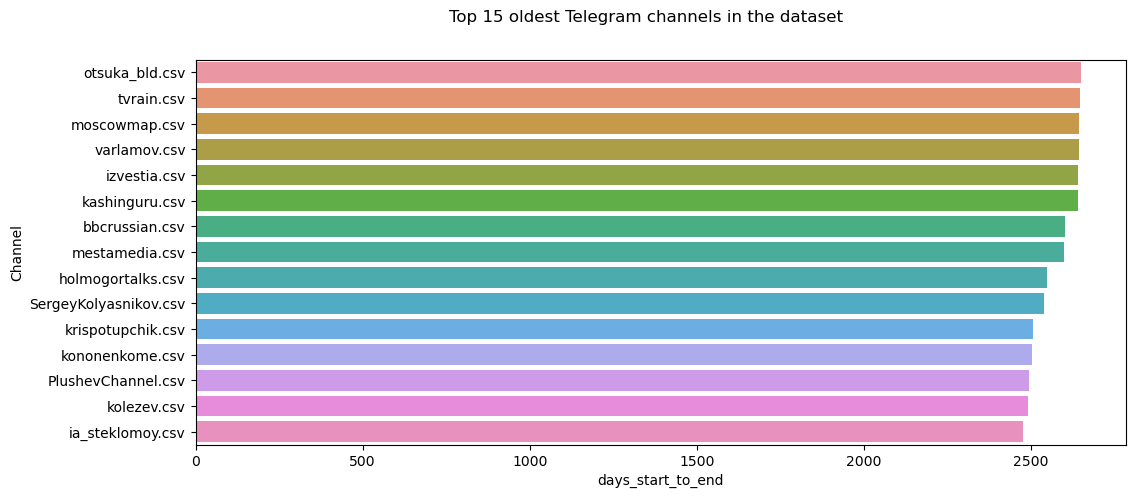

In [5]:
#create horizontal barplot
plt.rcParams["figure.figsize"] = [12, 5]
sns.barplot(x=start_end_df[['Channel', 'days_start_to_end']].sort_values(by=['days_start_to_end'], ascending=False).days_start_to_end.head(15), y=start_end_df[['Channel', 'days_start_to_end']].sort_values(by=['days_start_to_end'], ascending=False).Channel.head(15), orient='h')
plt.suptitle('Top 15 oldest Telegram channels in the dataset')
plt.show()

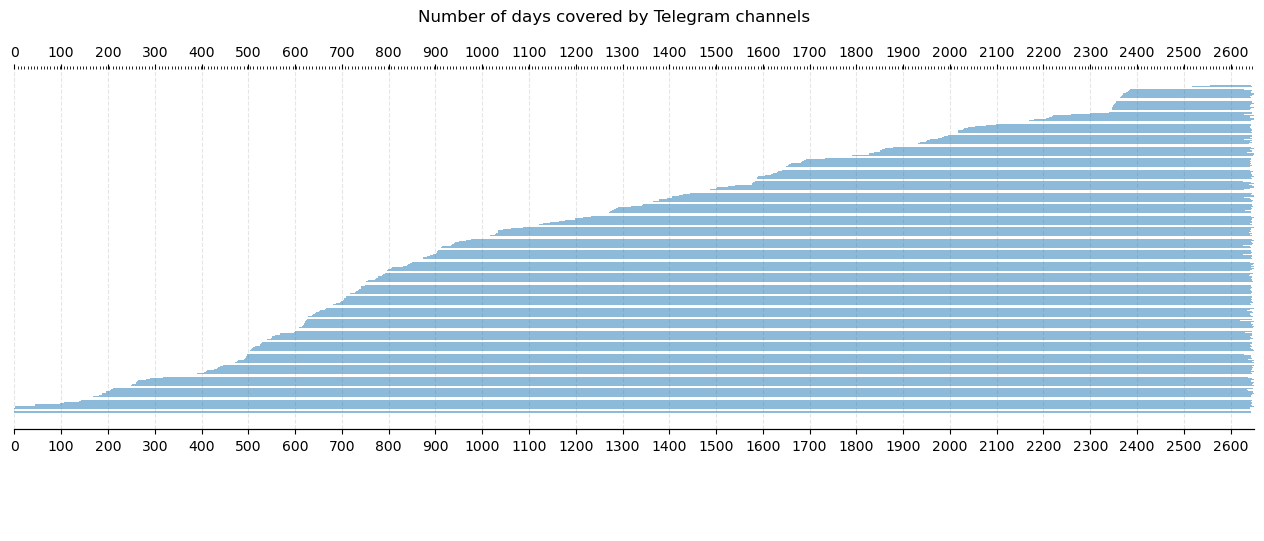

In [6]:
##### PLOT #####
fig, (ax, ax1) = plt.subplots(2, figsize=(16,6), gridspec_kw={'height_ratios':[6, 1]})
ax.barh(start_end_df.Channel, start_end_df.days_start_to_end, left=start_end_df.start_num, alpha=0.5)

# grid lines
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.2, which='both')

ax.xaxis.set_major_locator(MultipleLocator(100))
ax.set_yticks([])

ax_top = ax.twiny()

# align x axis
ax.set_xlim(0, start_end_df.end_num.max())
ax_top.set_xlim(0, start_end_df.end_num.max())

# top ticks (markings)
xticks_top_minor = np.arange(0, start_end_df.end_num.max()+1, 7)
ax_top.set_xticks(xticks_top_minor, minor=True)
# top ticks (label)
xticks_top_major = np.arange(3.5, start_end_df.end_num.max()+1, 7)
ax_top.set_xticks(xticks_top_major, minor=False)
ax_top.xaxis.set_major_locator(MultipleLocator(100))

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)

ax_top.spines['right'].set_visible(False)
ax_top.spines['left'].set_visible(False)
ax_top.spines['top'].set_visible(False)

plt.suptitle('Number of days covered by Telegram channels')

# clean second axis
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])

plt.show()

# Network analysis

In [8]:
def serch_channel_id(some_string):
    if pd.notnull(some_string):
        m = re.search('channel_id=(\d+)', some_string, re.IGNORECASE)
        if pd.notnull(m):
            return m.group(1)
        else:
            return None
    else:
        return None
    
def get_self_id(df):
    return serch_channel_id(df['to_id'].value_counts().index.to_list()[0])

<span style="color:blue">NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks</span>

https://networkx.org

In [5]:
import networkx as nx
import nx_altair as nxa

<span style="color:blue">It is necessary to convert all connections between chats into the format (2, 3, {'weight': 3.1415}), where weight will be the number of fwd_from messages</span>

In [32]:
def show_networkx(G, title=''):
    
    for f in G.nodes():
        G.nodes[f]["name"] = f
#     pos = nx.spring_layout(G)
#     pos = nx.spectral_layout(G)
    pos = nx.spiral_layout(G)

    # Draw the graph using Altair
    viz = nxa.draw_networkx(
        G, pos=pos,
        width='weight',
        edge_color='black',
        node_tooltip=['name']
    ).properties(
        width=800,
        height=500, title=title
    )

    # Show it as an interactive plot!
    return viz.interactive()

## Make networkx

In [9]:
names_id_dict = dict()
id_names_dict = dict()
for channel_name in tqdm(channels):
    channel = pd.read_csv(f'CSS_TG_data_v1/channels/{channel_name}', low_memory=False)
    if channel.shape[0] > 0:
        self_id = get_self_id(channel)
        names_id_dict[channel_name] = self_id
        id_names_dict[self_id] = channel_name

100%|█████████████████████████████████████████| 299/299 [00:59<00:00,  5.02it/s]


In [34]:
channels_networkx = dict()

for channel_name in tqdm(channels):
    channel = pd.read_csv(f'CSS_TG_data_v1/channels/{channel_name}', low_memory=False)
    if channel.shape[0] > 0:
        self_id = get_self_id(channel)
        channel['fwd_from_id'] = channel['fwd_from'].apply(lambda x: serch_channel_id(x))
        channel_s = channel['fwd_from_id'].value_counts()
        channel_s = channel_s[channel_s > 10]
        if len(channel_s) >0:
            channel_dict = channel_s.to_dict()
            channel_dict.pop(self_id, None)
            new_ch_list = list(channel_dict.keys())
            edges_list = []
            for new_ch in new_ch_list:
                if new_ch in id_names_dict.keys():
                    edges_list.append((id_names_dict[self_id], id_names_dict[new_ch], {'weight_e':channel_dict[new_ch]}))
            if len(edges_list) > 0:
                channels_networkx[channel_name] = edges_list
len(channels_networkx)

100%|█████████████████████████████████████████| 299/299 [01:06<00:00,  4.52it/s]


236

In [35]:
big_G = nx.MultiGraph()
h_names_list = list(channels_networkx.keys())
for h_name in h_names_list:
    big_G.add_edges_from(channels_networkx[h_name])
big_G.number_of_nodes()

285

In [36]:
GG = nx.Graph()
for n, nbrs in big_G.adjacency():
    for nbr, edict in nbrs.items():
        minvalue = min([d['weight_e'] for d in edict.values()])
        GG.add_edge(n, nbr, weight = minvalue)
GG.number_of_nodes()

285

In [37]:
import altair as alt
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [48]:
show_networkx(GG, title="Channels network where the width of connections between the nodes is the number of citations")


alt.LayerChart(...)

In [39]:
communities = list(nx.community.label_propagation_communities(GG))
centralities = nx.eigenvector_centrality(GG)

for f in GG.nodes():
    for i, c in enumerate(communities):
        if f in c:
            GG.nodes[f]["community"] = str(i)
            GG.nodes[f]["centrality"] = centralities[f]
            GG.nodes[f]["name"] = f

In [40]:
def filterTheDict(dictObj, callback):
    newDict = dict()
    # Iterate over all the items in dictionary
    for (key, value) in dictObj.items():
        # Check if item satisfies the given condition then add to new dict
        if callback((key, value)):
            newDict[key] = value
    return newDict

In [42]:
filtered_centralities = filterTheDict(centralities, lambda elem : elem[1] > 0.05)
print(len(filtered_centralities))

104


In [43]:
filtered_names = list(filtered_centralities.keys())
H = GG.subgraph(filtered_names)

In [49]:
# pos = nx.spring_layout(GG)
pos = nx.spiral_layout(GG)
            
chart = nxa.draw_networkx(
    G=H,
    pos=pos,
    node_size="centrality",
    node_color='community',
    cmap='accent',
    node_tooltip=['name', 'centrality', "community"]
).properties(
        width=800,
        height=500, title='Channels network with community labels and centrality values'
    )


chart.interactive()

alt.LayerChart(...)

<span style="color:blue">The networkx library is capable of analyzing communities, but the output shows that the channels in the dataset belong to the same community</span>

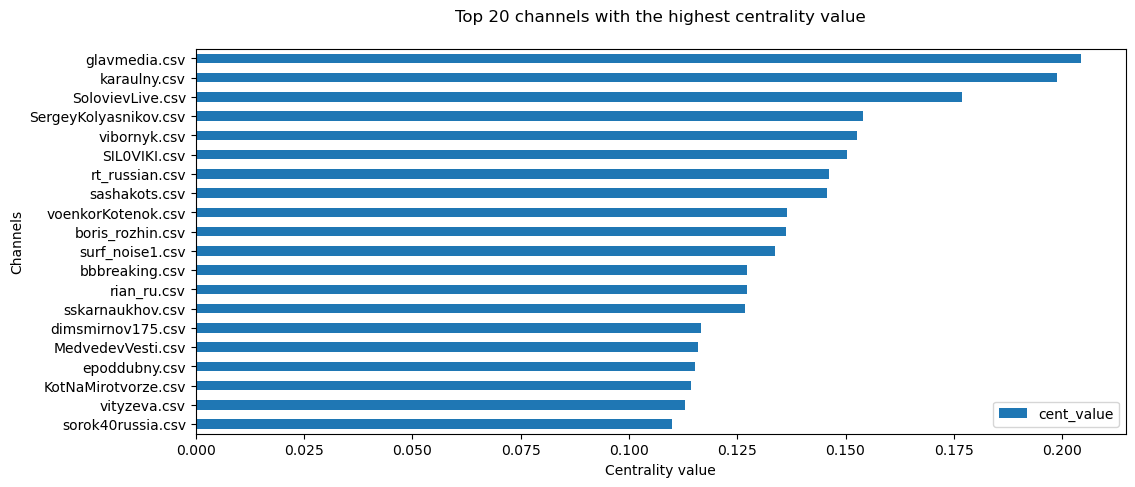

In [22]:
central_ch_df = pd.DataFrame(centralities.items(), columns=['Name', 'cent_value']).sort_values(by=['cent_value'], ascending=False).reset_index(drop=True)
central_ch_df[0:20].sort_values(by=['cent_value']).plot.barh(x='Name', y='cent_value')
plt.xlabel('Centrality value')
plt.ylabel('Channels')
plt.title('Top 20 channels with the highest centrality value',y=1.05)
plt.show()

In [23]:
top_chats_list = central_ch_df[0:20]['Name'].to_list()
print(top_chats_list)

['glavmedia.csv', 'karaulny.csv', 'SolovievLive.csv', 'SergeyKolyasnikov.csv', 'vibornyk.csv', 'SIL0VIKI.csv', 'rt_russian.csv', 'sashakots.csv', 'voenkorKotenok.csv', 'boris_rozhin.csv', 'surf_noise1.csv', 'bbbreaking.csv', 'rian_ru.csv', 'sskarnaukhov.csv', 'dimsmirnov175.csv', 'MedvedevVesti.csv', 'epoddubny.csv', 'KotNaMirotvorze.csv', 'vityzeva.csv', 'sorok40russia.csv']


In [24]:
top_channels_dfs = []
for channel_name in tqdm(top_chats_list):
    channel = pd.read_csv(f'CSS_TG_data_v1/channels/{channel_name}', low_memory=False)
    if channel.shape[0] > 0:
        channel['date_time'] = pd.to_datetime(channel['date'])
        channel['name'] = channel_name
        top_channels_dfs.append(channel)
top_channels_df = pd.concat(top_channels_dfs)

100%|███████████████████████████████████████████| 20/20 [00:18<00:00,  1.10it/s]


In [25]:
top_channels_df['year_month'] = top_channels_df['date_time'].dt.strftime('%Y-%m')
top_channels_df.head(2)

Unnamed: 0      id                       date  views reactions  \
0           0  223292  2022-12-23 10:28:07+00:00    1.0       NaN   
1           1  223291  2022-12-23 10:27:34+00:00    1.0       NaN   

                                to_id  \
0  PeerChannel(channel_id=1310493808)   
1  PeerChannel(channel_id=1310493808)   

                                            fwd_from  \
0  MessageFwdHeader(date=datetime.datetime(2022, ...   
1  MessageFwdHeader(date=datetime.datetime(2022, ...   

                                             message   type  duration  \
0  ‼️Россия использует зиму как оружие — Байден\n...  video      33.0   
1                                                NaN  video       7.0   

                  date_time           name year_month  
0 2022-12-23 10:28:07+00:00  glavmedia.csv    2022-12  
1 2022-12-23 10:27:34+00:00  glavmedia.csv    2022-12

In [26]:
print("Top 20 channels with hiest centrality value during the period FROM: ", top_channels_df['date_time'].min(), "To: ", top_channels_df['date_time'].max(), "posted", top_channels_df.shape[0], "messages")

Top 20 channels with hiest centrality value during the period FROM:  2016-01-06 13:09:36+00:00 To:  2022-12-26 10:59:50+00:00 posted 1827691 messages


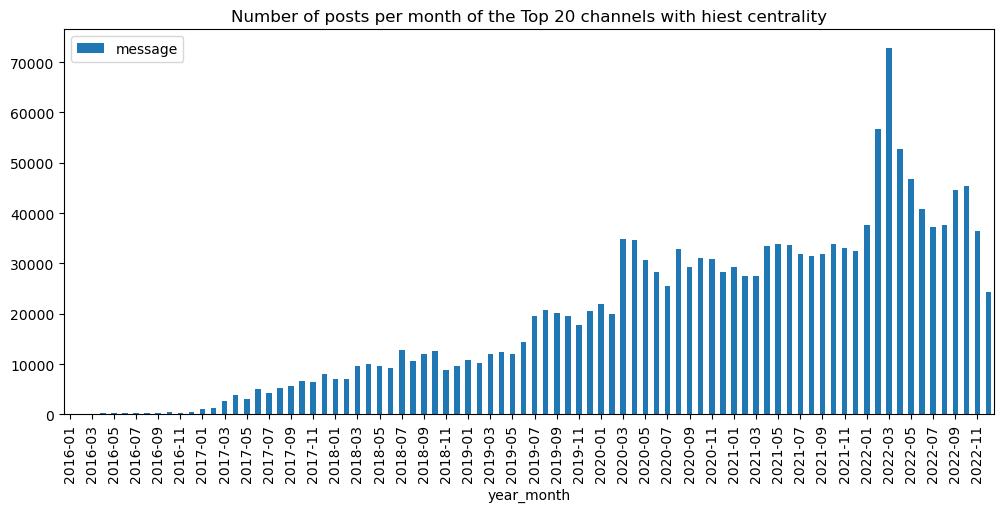

In [27]:
ax = top_channels_df[["year_month", "message"]].groupby(["year_month"]).count().plot.bar(rot=90, title='Number of posts per month of the Top 20 channels with hiest centrality')
ax.xaxis.set_major_locator(MultipleLocator(2))
plt.rcParams["figure.figsize"] = [12, 5]
plt.show()

<span style="color:blue">During the March 2022 these 20 Telegram channels posted (and reposted) more than 70000 messages.</span>

## Glavmedia - the top propaganda Telegram channel

In [27]:
glavmedia_df = top_channels_df[top_channels_df['name'] == 'glavmedia.csv']

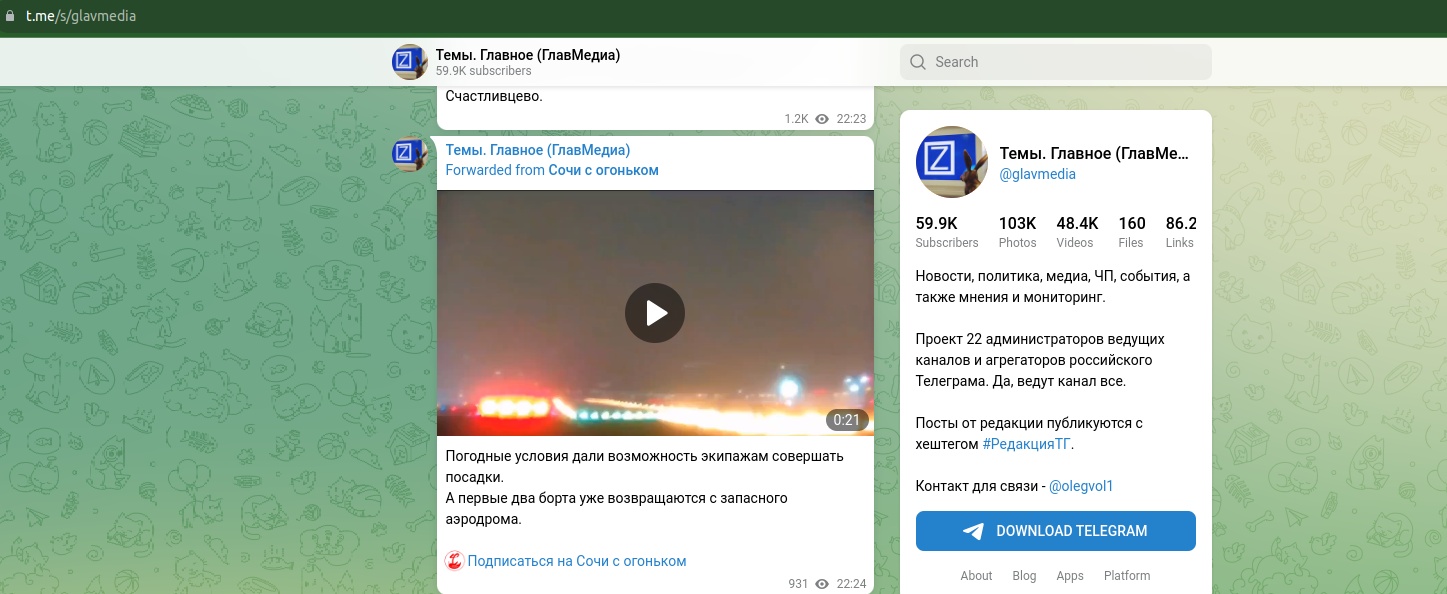

In [28]:
print("The Glavmedia channel during the period FROM: ", glavmedia_df['date_time'].min(), "To: ", glavmedia_df['date_time'].max(), "posted", glavmedia_df.shape[0], "messages")

The Glavmedia channel during the period FROM:  2019-07-01 10:30:43+00:00 To:  2022-12-23 10:28:07+00:00 posted 218510 messages


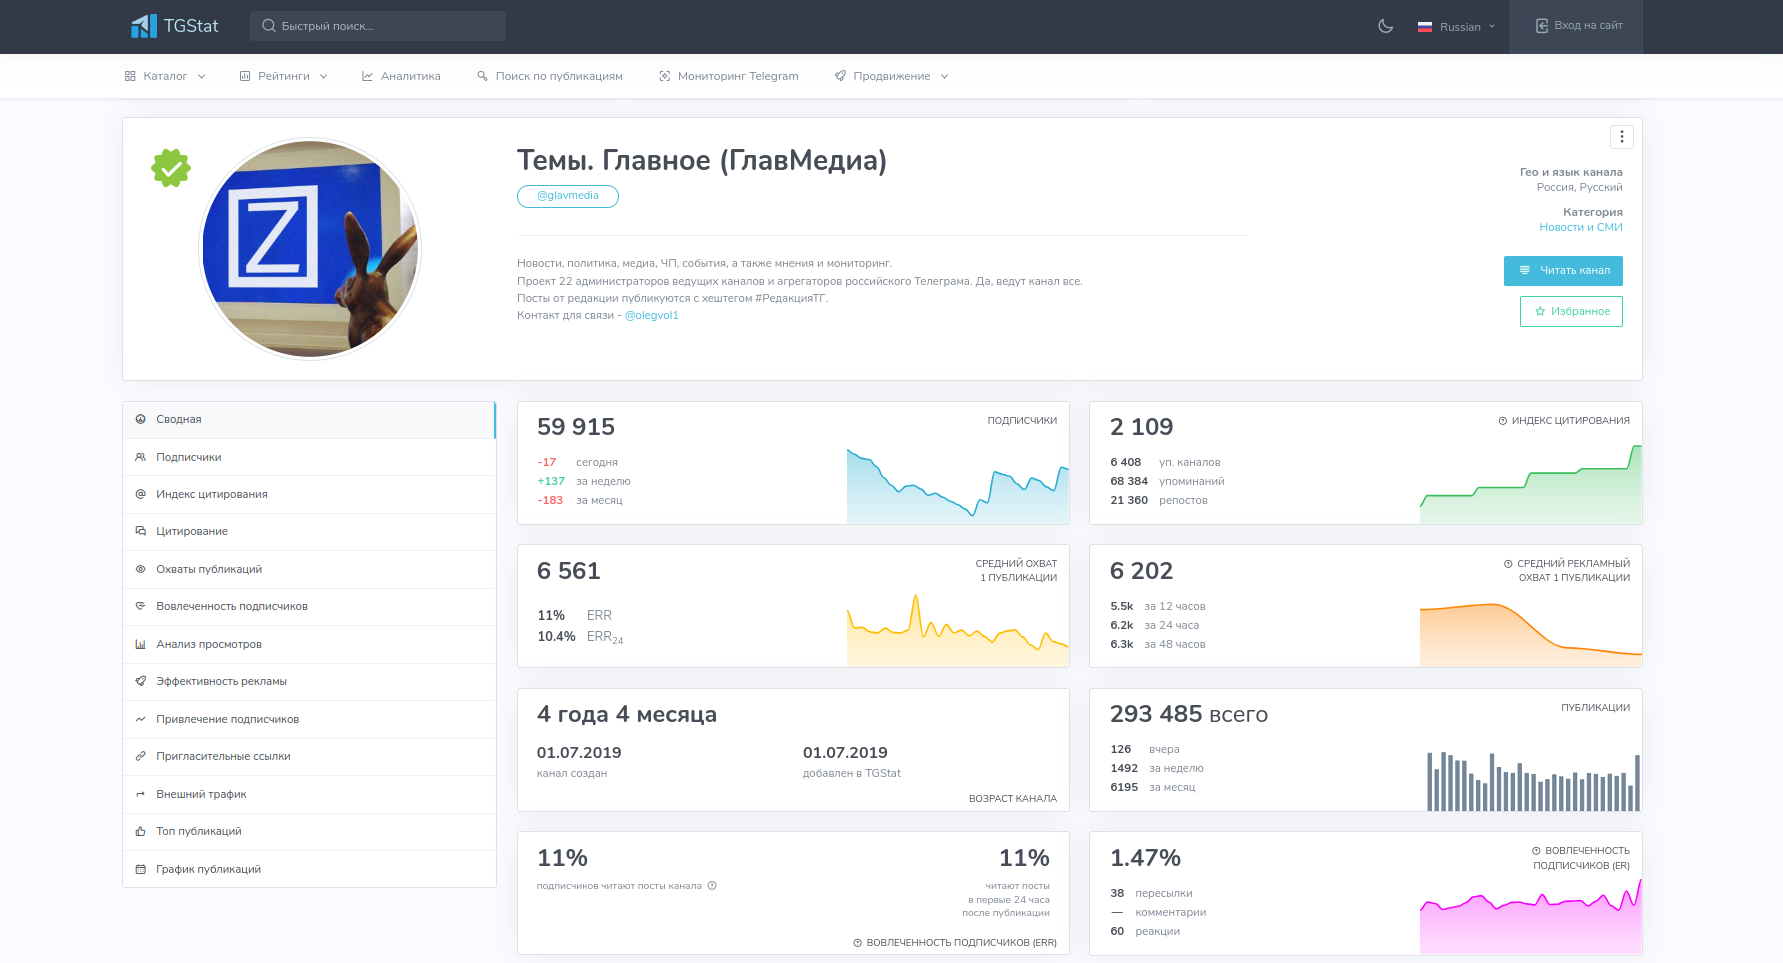

<span style="color:blue">It seems that this channel collects news from other channels and may be used as a source as well.</span>

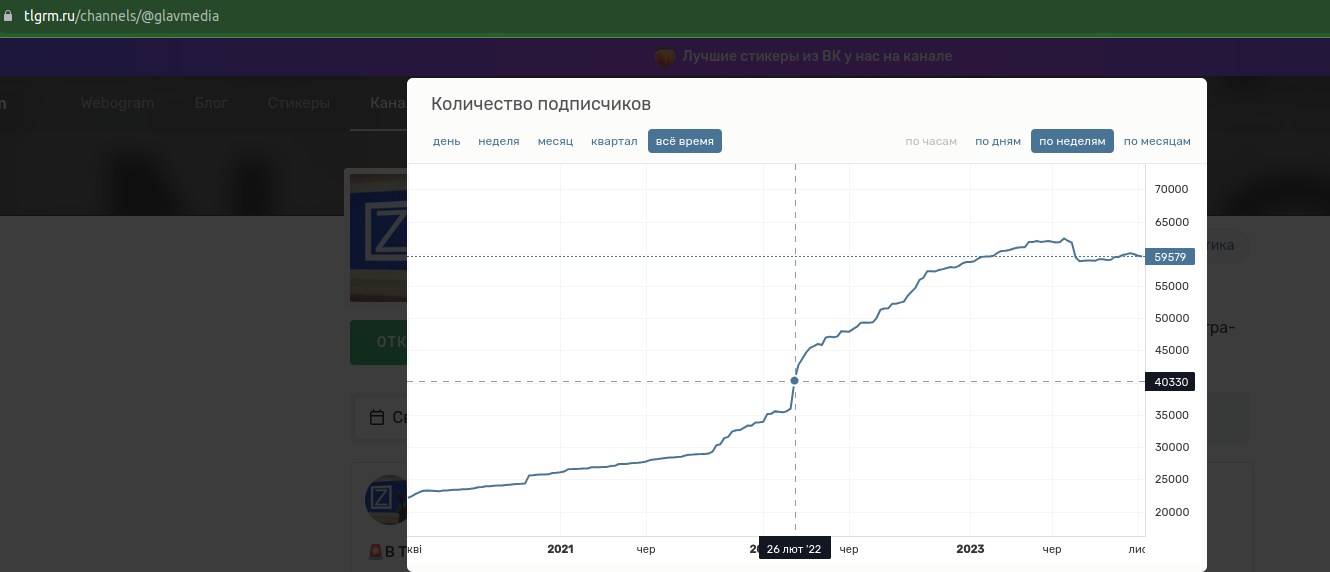

<span style="color:blue">We can see a sharp increase in followers in the first days of a full-scale Russian invasion of Ukraine.</span>

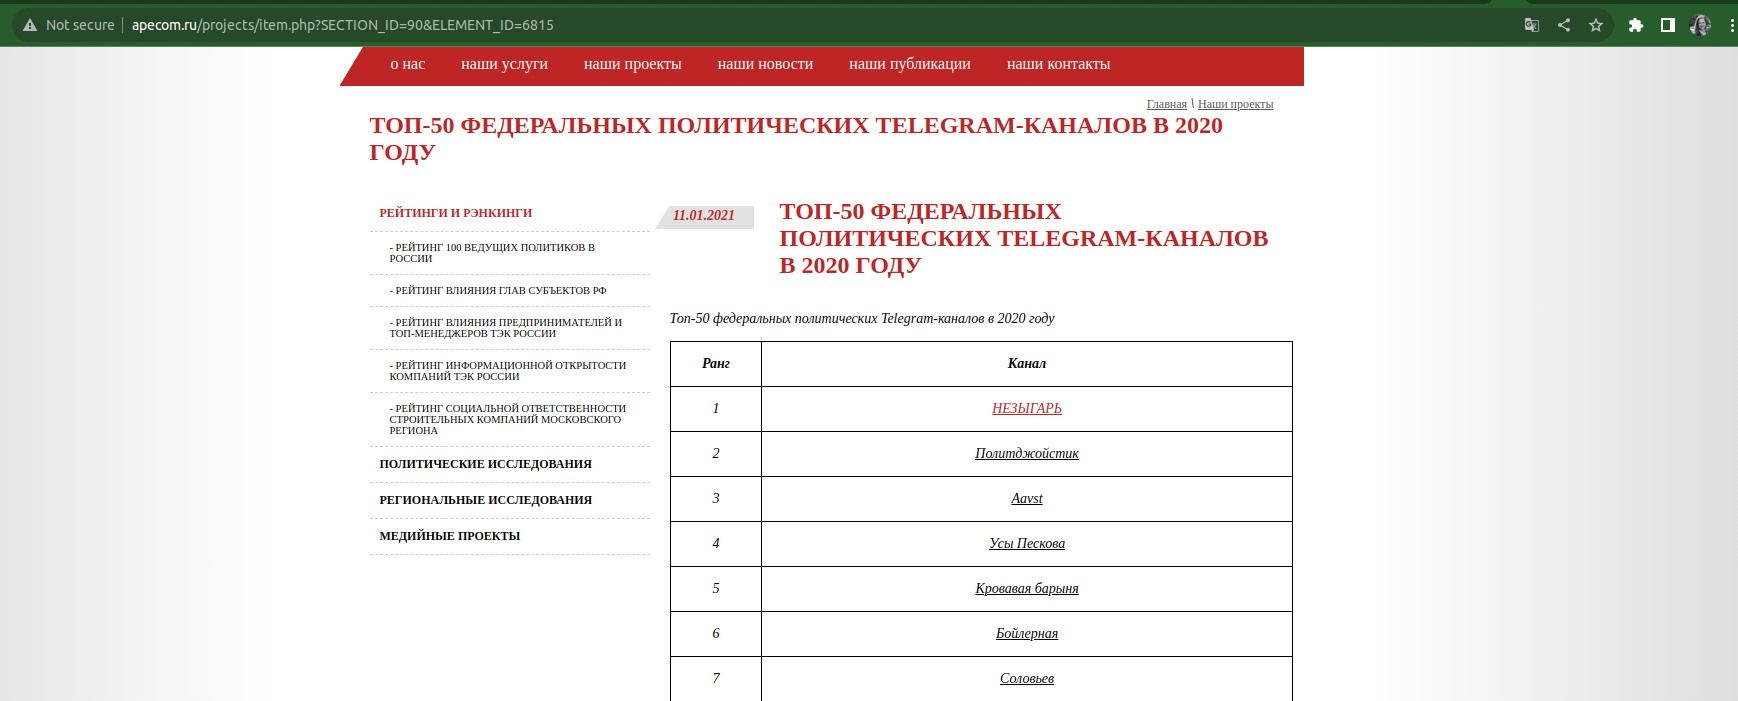
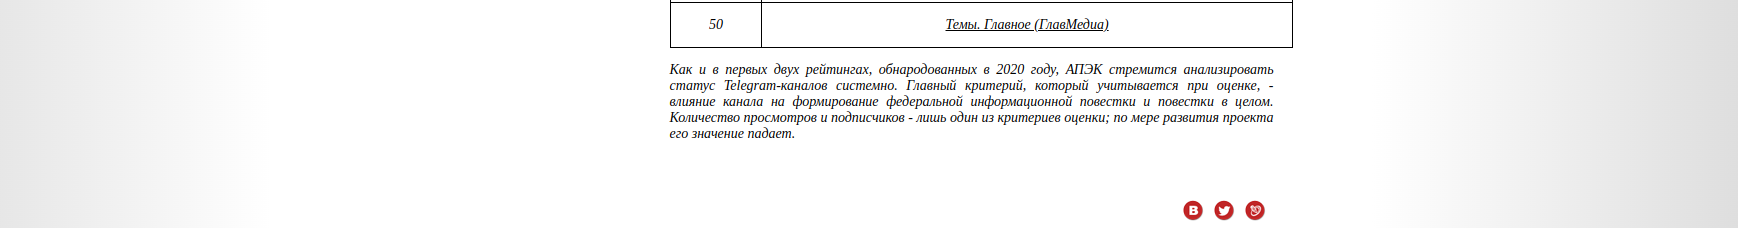

<span style="color:blue">The Glavmedia channel is included into the top 50 federal political Telegram channels in 2020</span>

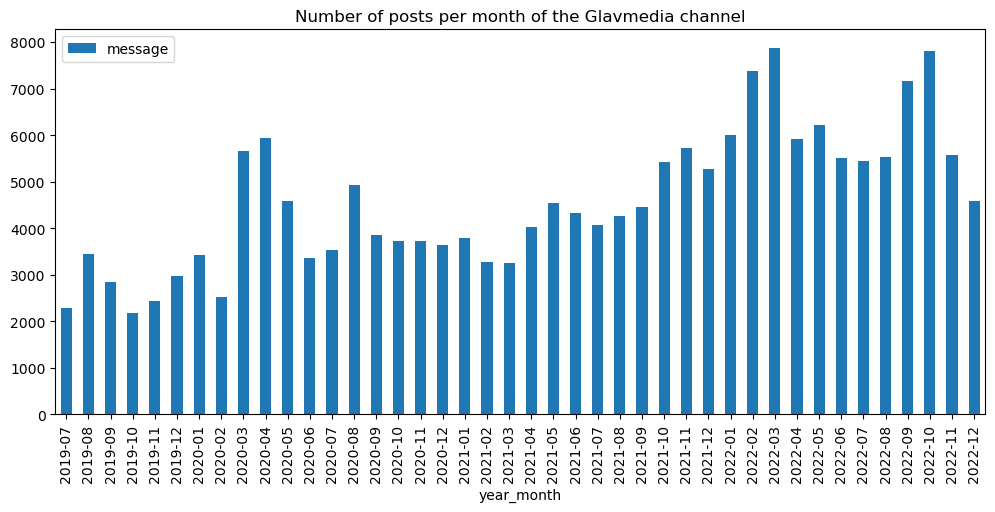

In [29]:
ax = glavmedia_df[["year_month", "message"]].groupby(["year_month"]).count().plot.bar(rot=90, title='Number of posts per month of the Glavmedia channel')
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.rcParams["figure.figsize"] = [12, 5]
plt.show()

<span style="color:blue">This channel follows the same pattern with other channel from the top 20. During the March 2022 it posted (and reposted) about than 8000 messages. </span>

# Reactions and message types

<span style="color:blue">We selected several time periods to analyze the data set</span>

In [28]:
# Chosen periods of time for Term Frequency Inverse Document Frequency analysis
periods_list_1 = [('2016-01-06', '2017-01-01'), ('2017-01-01', '2018-01-01'), ('2018-01-01', '2019-01-01'),
               ('2019-01-01', '2020-01-01'), ('2020-01-01', '2021-01-01'), ('2021-01-01', '2021-06-01'),
               ('2021-06-01', '2022-01-01'), ('2022-01-01', '2022-02-23'), ('2022-02-23', '2022-08-01'),
               ('2022-08-01', '2022-12-26')]

periods_list_2 = [('2016-01-06', '2016-07-01'), ('2016-07-06', '2017-01-01'), 
                  ('2017-01-01', '2017-07-01'), ('2017-07-01', '2018-01-01'),
                  ('2018-01-01', '2018-07-01'), ('2018-07-01', '2019-01-01'), 
                  ('2019-01-01', '2019-07-01'), ('2019-07-01', '2020-01-01'),
                  ('2020-01-01', '2020-07-01'), ('2020-07-01', '2021-01-01'),
                  ('2021-01-01', '2021-07-01'), ('2021-07-01', '2022-01-01'),
                  ('2022-01-01', '2022-07-01'), ('2022-07-01', '2023-01-01')]

periods_list_3 = [('2020-01-01', '2020-04-01'), ('2020-04-01', '2020-07-01'),
                  ('2020-07-01', '2020-10-01'), ('2020-10-01', '2021-01-01'),
                  ('2021-01-01', '2021-04-01'), ('2021-04-01', '2021-07-01'),
                  ('2021-07-01', '2021-10-01'), ('2021-10-01', '2022-01-01'),
                  ('2022-01-01', '2022-04-01'), ('2022-04-01', '2022-07-01'),
                  ('2022-07-01', '2022-10-01'), ('2022-10-01', '2023-01-01'),]

### Message types 

In [31]:
message_type_s_list = []
for period in tqdm(periods_list_2):
    from_p = period[0]
    to_p = period[1]
    test_df = top_channels_df[(top_channels_df['date_time']>from_p) & (top_channels_df['date_time']<to_p)]
    message_type_s_list.append(test_df['type'].value_counts().reset_index().rename(columns={'count':period[1]}).set_index('type'))


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 42.97it/s]


In [32]:
message_type_df = pd.concat(message_type_s_list, axis=1)

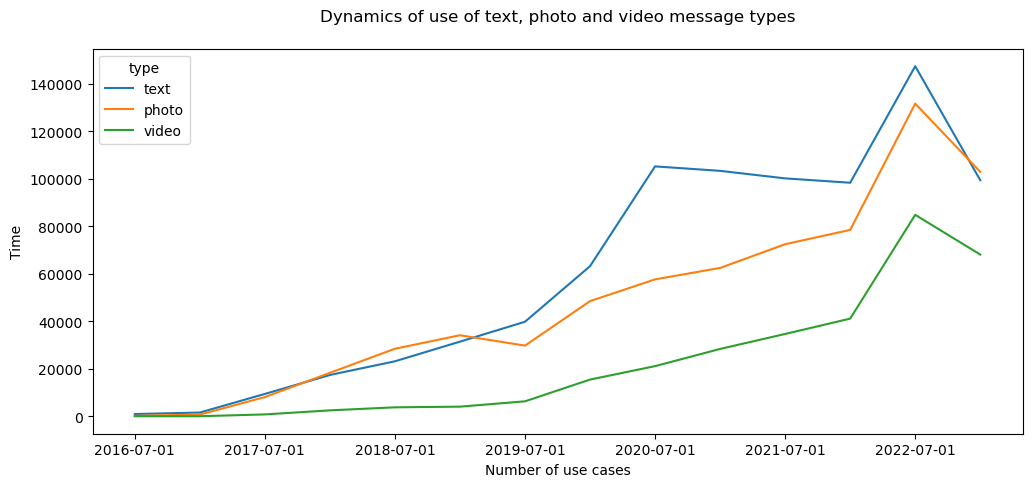

In [33]:
message_type_df[0:3].T.plot.line()
plt.xlabel('Number of use cases')
plt.ylabel('Time')
plt.title('Dynamics of use of text, photo and video message types',y=1.05)
plt.show()

<span style="color:blue">We can see a spike in all message types between "2022-01-01" and "2022-07-01".</span>

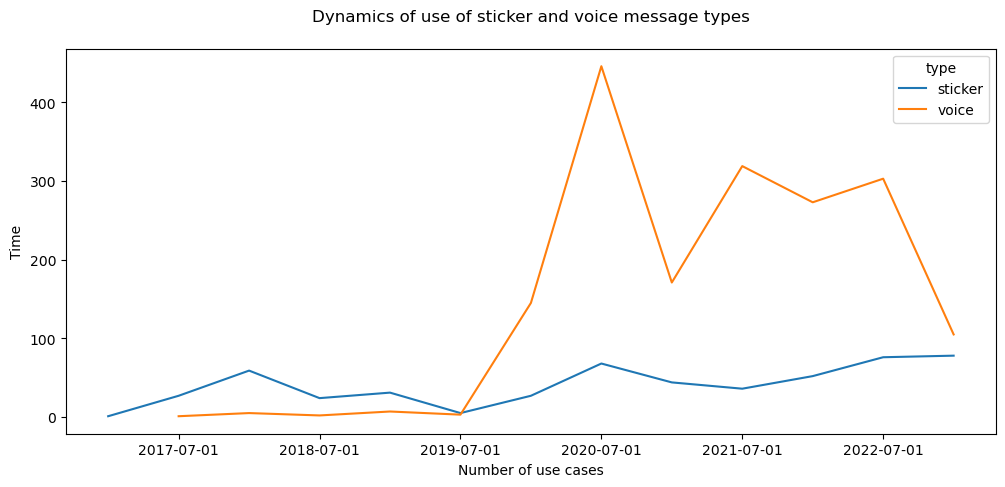

In [34]:
message_type_df[3:].T.plot.line()
plt.xlabel('Number of use cases')
plt.ylabel('Time')
plt.title('Dynamics of use of sticker and voice message types',y=1.05)
plt.show()

<span style="color:blue">During "01-01-2020" and "01-07-2020", voice messages were quite popular.</span>

### Reactions

<span style="color:blue">For the first attempt, we divided the timeline into half-years, but the main number of reactions was in 2022, so we decided to divide the year into quarters.</span>

<span style="color:blue">The screenshot below shows the distribution of the number of reactions.</span>

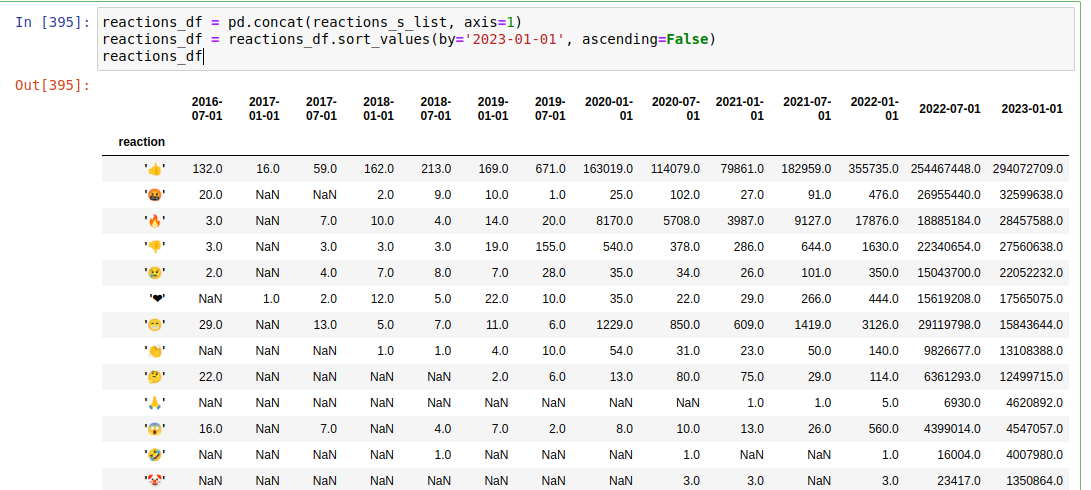

In [35]:
reactions_s_list = []
for period in tqdm(periods_list_3):
    from_p = period[0]
    to_p = period[1]
    test_df = top_channels_df[(top_channels_df['date_time']>from_p) & (top_channels_df['date_time']<to_p)]
    message_type_s_list.append(test_df['type'].value_counts().reset_index().rename(columns={'count':period[1]}).set_index('type').copy())
    
    reactions_list = []
    for i in range(len(test_df)):
        text = test_df.iloc[i]['reactions']
        if pd.notnull(text):
            if 'ReactionEmoji' in text:
                emoticon_list = re.findall(r'reaction=ReactionEmoji(.*?), chosen_order', text) 
                for emo in emoticon_list:
                    emo_list = emo.split(',')
                    reactions_list.append((re.search(r'\(emoticon=(.*?)\)', emo_list[0]).group(1), int(emo_list[1].split('=')[1])))
            else:
                text = text.replace('MessageReactions(results=[ReactionCount', '')
                text = text.strip(')')
                match = re.findall(r'\((.*?)\)', text) 
                for mat in match:
                    reaction = mat.split(',')
                    if reaction:
                        reaction = [el.strip() for el in reaction]
                        reaction = reaction[0:2]
                        reactions_list.append((reaction[0].split('=')[1], int(reaction[1].split('=')[1])))

    reactions_df = pd.DataFrame(reactions_list, columns =['reaction', 'count'])
    reactions_s_list.append(reactions_df.groupby('reaction').sum().reset_index().rename(columns={'count':period[1]}).set_index('reaction').copy())

print(len(reactions_s_list))

100%|███████████████████████████████████████████| 12/12 [00:40<00:00,  3.36s/it]

12


In [36]:
reactions_df = pd.concat(reactions_s_list, axis=1)
reactions_df = reactions_df.sort_values(by='2023-01-01', ascending=False)
reactions_df.head()

2020-04-01  2020-07-01  2020-10-01  2021-01-01  2021-04-01  \
reaction                                                               
'👍'            692.0       586.0       676.0       629.0      2749.0   
'🤬'            196.0       100.0        21.0         8.0       160.0   
'🔥'             31.0        15.0        28.0        25.0       131.0   
'👎'             34.0        13.0        32.0        22.0        59.0   
'😢'             33.0        53.0        17.0        20.0        62.0   

          2021-07-01  2021-10-01  2022-01-01  2022-04-01   2022-07-01  \
reaction                                                                
'👍'           1451.0      3562.0      6067.0  47353089.0  203932413.0   
'🤬'             24.0       265.0       540.0   6831420.0   22371559.0   
'🔥'             36.0       215.0       335.0   2735768.0   16308261.0   
'👎'             55.0       189.0       419.0   1724686.0   20618071.0   
'😢'             79.0       995.0       250.0   2534891.0   13013698.0   

           2022-10-01   2023-01-01  
reaction                            
'👍'       144964202.0  148366852.0  
'🤬'        17863929.0   17245930.0  
'🔥'        12720357.0   16159948.0  
'👎'        13704120.0   13835208.0  
'😢'        11953402.0   10654044.0

In [37]:
emg_list = reactions_df.index.tolist()
print(len(emg_list))
print(emg_list[0:10])
print(emg_list[10:20])
print(emg_list[20:30])
print(emg_list[30:39])

39
["'👍'", "'🤬'", "'🔥'", "'👎'", "'😢'", "'❤'", "'😁'", "'👏'", "'🤔'", "'🤣'"]
["'🙏'", "'😱'", "'🤡'", "'❤\\u200d🔥'", "'⚡'", "'🤯'", "'🎉'", "'💯'", "'🥴'", "'🥱'"]
["'😐'", "'👌'", "'🌚'", "'🥰'", "'🖕'", "'🏆'", "'🤩'", "'🌭'", "'💔'", "'🤨'"]
["'😍'", "'🐳'", "'🍾'", "'🕊'", "'😭'", "'💋'", "'😨'", "'🤮'", "'💩'"]


In [38]:
positive_negative_list = ['pos', 'neg', 'pos', 'neg', 'neg', 'pos', 'pos', 'neg', 'pos', 'pos',
                          'pos', 'neg', 'neg', 'pos', 'pos', 'neg', 'pos', 'pos', 'neg', 'neg',
                          'neg', 'pos', 'neg', 'pos', 'neg', 'pos', 'pos', 'neg', 'neg', 'neg',
                          'pos', 'pos', 'pos', 'pos', 'neg', 'pos', 'neg', 'neg', 'neg']
len(positive_negative_list)

39

In [39]:
reactions_df['reaction_class'] = positive_negative_list
reactions_df.head(10)

2020-04-01  2020-07-01  2020-10-01  2021-01-01  2021-04-01  \
reaction                                                               
'👍'            692.0       586.0       676.0       629.0      2749.0   
'🤬'            196.0       100.0        21.0         8.0       160.0   
'🔥'             31.0        15.0        28.0        25.0       131.0   
'👎'             34.0        13.0        32.0        22.0        59.0   
'😢'             33.0        53.0        17.0        20.0        62.0   
'❤'             18.0        11.0        13.0        21.0       252.0   
'😁'             86.0         9.0        23.0        27.0       654.0   
'👏'             14.0        17.0        10.0        13.0        28.0   
'🤔'              3.0        77.0        15.0        61.0        21.0   
'🤣'              NaN         1.0         NaN         NaN         NaN   

          2021-07-01  2021-10-01  2022-01-01  2022-04-01   2022-07-01  \
reaction                                                                
'👍'           1451.0      3562.0      6067.0  47353089.0  203932413.0   
'🤬'             24.0       265.0       540.0   6831420.0   22371559.0   
'🔥'             36.0       215.0       335.0   2735768.0   16308261.0   
'👎'             55.0       189.0       419.0   1724686.0   20618071.0   
'😢'             79.0       995.0       250.0   2534891.0   13013698.0   
'❤'             55.0       803.0       393.0   4120652.0   12510239.0   
'😁'             44.0       372.0       290.0  10290809.0   21798079.0   
'👏'             22.0        79.0        61.0   1258735.0    8570767.0   
'🤔'              8.0        32.0        82.0    882503.0    5478790.0   
'🤣'              NaN         NaN         1.0        13.0      15991.0   

           2022-10-01   2023-01-01 reaction_class  
reaction                                           
'👍'       144964202.0  148366852.0            pos  
'🤬'        17863929.0   17245930.0            neg  
'🔥'        12720357.0   16159948.0            pos  
'👎'        13704120.0   13835208.0            neg  
'😢'        11953402.0   10654044.0            neg  
'❤'        10344078.0    8530695.0            pos  
'😁'        10970597.0    7672262.0            pos  
'👏'         5948737.0    7159651.0            neg  
'🤔'         5593468.0    6907616.0            pos  
'🤣'          730217.0    3277763.0            pos

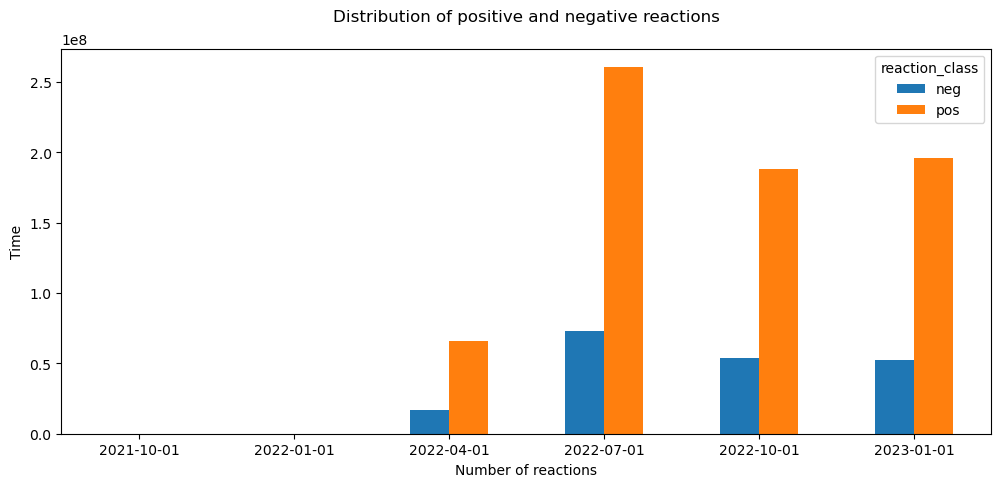

In [40]:
reactions_df.groupby(['reaction_class']).sum().T[6:].plot.bar(rot=0)
plt.xlabel('Number of reactions')
plt.ylabel('Time')
plt.title('Distribution of positive and negative reactions',y=1.05)
plt.show()

<span style="color:blue">In general, the majority of reactions are positive. The largest number of reactions was from '2022-04-01' to '2022-07-01'. It is interesting that before the start of the invasion from '2022-01-01' to '2022-04-01' there were significantly fewer rections compared to the following 3 months.</span>

# Text preprocessing

In [41]:
print(top_channels_df.shape)
# Drop NA
top_channels_df = top_channels_df.dropna(subset=['message'])

# Drop NA duplicates
top_channels_df.drop_duplicates(subset ="message",
                     keep = 'first', inplace = True)
top_channels_df = top_channels_df.reset_index(drop=True)
top_channels_df.shape

(1827691, 13)


(1393528, 13)

In [42]:
# the number of removed duplicates
1827691-1393528

434163

In [43]:
# remove rows where usernames like @karaulny more than 5 in one message

def count_usernames(text):
    match = re.findall("@([A-Za-z0-9]+)", text)
    return len(match)

text = """Агрегаторы:
@karaulny - Караульный
@vibornyk - Выборный 
@glavmedia - Темы. Главное
@gogoKremlin 
@navideovidno - На видео видно"""

count_usernames(text)

5

In [44]:
top_channels_df['num_usernames'] = top_channels_df['message'].apply(lambda x: count_usernames(x))

In [45]:
top_channels_df.shape[0] - top_channels_df[top_channels_df['num_usernames'] == 0].shape[0]

169794

<span style="color:blue">There are 169794 messages that promote other Telegram channels and should be excluded from the dataset.</span>

In [46]:
top_channels_df = top_channels_df[top_channels_df['num_usernames'] == 0].reset_index(drop=True) 
top_channels_df.shape

(1223734, 14)

In [47]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

[nltk_data] Downloading package stopwords to /home/pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
stopwords_list_extend = ['наш', 'день', 'видео', 'дело', 'новость', 'год', 'хороший', 'россия', 'российский', 
                         'свой', 'мочь', 'человек', 'весь', 'который', 'это', 'новый', 'подборка', 'вечер', 
                         'фото', 'утро', 'rt', 'russian', 'com', 'друг', 'article', 'читать', 'смотреть', 'ночь', 
                         'рассказывать', 'упс', 'фотогалерея', 'завтра', 'страна', 'очень', 'добрый', 'дорогой',
                         'просто', 'сегодня', 'сказать', 'читатель', 'знать', 'субботний', 'вести', 'прямой',
                         'трансляция', '', 'т е', 'p s', 'ст', ' ']

russian_stopwords.extend(stopwords_list_extend)

In [49]:
def clean_text(text):
    c = text[:]
    c = c.lower()
    c = re.sub("(https?\://)\S+", " ", c) # Remove links
    c = re.sub("(\\n)|\n|\r|\t", " ", c) # Remove CR, tab, and LR
    c = re.sub("(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4})", " ", c) # Remove dates
    c = re.sub("@([A-Za-z0-9]+)", " ", c) # Remove usernames
    c = re.sub("[0-9]", "", c) # Remove numbersz
    c = re.sub("\:|\/|\#|\.|\?|\!|\&|\"|\,", " ", c) # Remove symbols
    c = re.sub('[^\w]', " ", c)
    c = re.sub("_", " ", c) # Make spaces for the camel case text
    return c

clean_text('@karaulny - Караульный новый')

'    караульный новый'

In [50]:
#Preprocess function
def preprocess_text(text_one, sent_tokenize = False):
    #Create lemmatizer and stopwords list
    text = text_one[:]
    sents = nltk.sent_tokenize(text)
    clean_sents = []
    for text in sents:
        text = clean_text(text)
        tokens = mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in russian_stopwords\
#                   and token != " " and token != "" \
                  and token.strip() not in punctuation]
        text = " ".join([tok.strip()for tok in tokens])
        if len(text) > 0:
            clean_sents.append(text)
    if not sent_tokenize:
        return " ".join(clean_sents)
    else:
        return clean_sents
    

preprocess_text(top_channels_df.iloc[2]['message'], sent_tokenize = True)

['архангельск обстреливать травматика депутат городской дума неизвестный несколько выстреливать машина депутат петр ватутин перекресток центр архангельск',
 'парламентарий пострадать полицейский искать стрелка',
 'декабрь пересечение проспект ломоносов улица серафимович неизвестный мужчина четыре выстреливать стекло машина',
 'предположительно выстрел производиться травматический пистолет',
 'автомобиль момент покушение находиться депутат городской дума петр ватутин',
 'парламентарий получать серьезный травма написать заявление полиция',
 'страж порядок заниматься поиск стрелка',
 'петр ватутин являться владелец сеть пиццерия престо городской парламент возглавлять фракция справедливый']

In [51]:
top_channels_df['preproc_text'] = top_channels_df['message'].apply(lambda x: preprocess_text(x, sent_tokenize = True))


In [52]:
def len_text(sent_list):
    return len(" ".join(sent_list))

len_text(['aaa aaa', 'bbb b', 'ccc'])

17

In [53]:
top_channels_df['message_len'] = top_channels_df['preproc_text'].apply(lambda x: len_text(x))

In [54]:
top_channels_df.shape[0] - top_channels_df[top_channels_df['message_len'] > 50].shape[0]

156618

<span style="color:blue">The dataset contains 156,618 messages with payload tokens less than 50 characters long. We should remove them from the analysis.</span>

In [55]:
top_channels_df = top_channels_df[top_channels_df['message_len'] > 50].reset_index(drop=True)
top_channels_df.shape

(1067116, 16)

In [56]:
top_channels_df.to_csv('top_channels_df_preproc_text.csv')

In [ ]:
# download the dataset
top_channels_df = pd.read_csv('top_channels_df_preproc_text.csv')
top_channels_df['preproc_text'] = top_channels_df['preproc_text'].apply(lambda x: x.strip('][').replace("'", "").split(', '))

# Analysis of the most frequent words over time

In [30]:
top_channels_df['words_text'] = top_channels_df['preproc_text'].apply(lambda x: " ".join(x))

In [31]:
top_channels_df.iloc[1000]['words_text']

'установка защитный купол заэс свидетельствовать вещь намерен принимать мера предотвращение возможный авария станция результат обстрел сторона всу становиться возводить укрытие обстреливать заэс усложнять задача последний месседж полезно внедрять западный инфополь сей пора делать вид стоять обстрел станция'

In [23]:
list(top_channels_df.iloc[1000]['preproc_text'])

['установка защитный купол заэс свидетельствовать вещь',
 'намерен принимать мера предотвращение возможный авария станция результат обстрел сторона всу',
 'становиться возводить укрытие обстреливать заэс усложнять задача',
 'последний месседж полезно внедрять западный инфополь сей пора делать вид стоять обстрел станция']

In [6]:
for period in periods_list_2:
    from1 = period[0]
    to1 = period[1]
    period_1_df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
    print("From", from1, "to", to1, 'the dataset has', period_1_df.shape[0], 'messages')
    
    count_w_series_1 = pd.Series(np.concatenate([x.split() for x in period_1_df['words_text'].to_list()])).value_counts()
    print('Top 15 most frequent words:', ", ".join(count_w_series_1.head(15).index.tolist()))
    print()

From 2016-01-06 to 2016-07-01 the dataset has 749 messages
Top 15 most frequent words: сша, рф, украина, самый, путин, интересный, турция, ес, сирия, крым, вечерний, военный, победа, время, предлагать

From 2016-07-06 to 2017-01-01 the dataset has 1541 messages
Top 15 most frequent words: сша, самый, путин, сирия, трамп, украина, клинтон, президент, сми, первый, почему, пока, становиться, заявлять, глава

From 2017-01-01 to 2017-07-01 the dataset has 12093 messages
Top 15 most frequent words: навальный, путин, сша, самый, москва, президент, время, трамп, говорить, становиться, первый, украина, давать, заявлять, сообщать

From 2017-07-01 to 2018-01-01 the dataset has 25270 messages
Top 15 most frequent words: путин, самый, время, президент, навальный, становиться, говорить, москва, сша, первый, вопрос, выборы, давать, канал, русский

From 2018-01-01 to 2018-07-01 the dataset has 34945 messages
Top 15 most frequent words: путин, время, сша, самый, становиться, первый, говорить, президент

# TF-IDF Vectorization

## Результати аналізу пропаганди протягом 2016 - 2023 років

Підсумки проведеного нижче дослідження за допомогою алгоритму TF-IDF. Цей алгоритм дозволяє вирахувати важливість слова в корпусі документів.

Цікаво поспостерігати за розвитком пропагандистських ідей. Аналізуючи найважливіші пости кожні пів року від 2016 до 2023 року можна побачити яким чином россійські пропагандисти готували читачів до повномасштабного вторгнення.

### 2016 рік

Пропагандист Сергей Zergulio Колясников закликає приєднуватись до його телеграм каналу і привідкриває завісу грандіозних планів: 
- "После того, как группа наберет весомую численность, состоящую из реальных, подчеркиваю, людей, мы с ребятами приступим к реализации второго этапа, который, поверьте, будет очень интересен и важен для всех нас, но озвучивать детали пока не буду - а то у определенной категории граждан нежные места подгорят."

Повідомлення з найбільшими переглядами "«Мы вместе вывозили раненых детей»: корреспондент RT о работе с Доктором Лизой в Донбассе"

В найважливіших постах пишуть про:
- нову тему - Патріотизм
- ⚡️В Европарламенте одобрили проект резолюции о контрпропаганде в отношении стран. В частности, в документе утверждается, что Россия ведёт информационную войну против Евросоюза

Пропагандити жаліються що "В украинском Тернополе запретили песни в исполнении журналистов, Охлобыстина и Депардье" і "Эсминец ВМС США USS Donald Cook находится в Балтийском море для оказания военного давления на Россию".

### 2017 рік

Найтиражованіший пост попереджає громадян що буде з тими, хто піде на протест:
- ⚡️Полиция задержала участника протестной акции в Москве, который распылил перцовый газ в лицо сотруднику ОМОНа. В его отношении будет заведено уголовное дело. Возможно, оно будет объединено с делами тех, кто вырывал задерживаемых из рук ОМОН, бил их кулаками, а также юноши, который ударил ногой в голову упавлешего сотрудника Росгвардии

В найважливіших постах пишуть про "Русскую весну" і про "принизливий мир" :
- Как Сирия с Ираком помогли осознать "Русскую весну"
- От каких завоеваний могли отказаться вы, приведшие Россию к позорному миру, унизительные условия которого даже вы сами не решались обнародовать полностью? Вместо аннексий и контрибуций великая наша Родина завоевана, умалена, расчленена, и в уплату наложенной на нее дани вы тайно вывозите в Германию не вами накопленное золото.

### 2018 рік

Найголовніша думка, яку вкладають в голови росіян:
- Украина вернулась к своему любимому состоянию – тотальному хутору. почти нет мужиков моего возраста, т.е. 35-40 лет.
- В 22 регионах  сидят технократы, демонстрирующие бульдожью хватку и опыт танковых технократических тренингов. 

Найтиражованіший месседж: 💥Крымский кризис. Полное видео тарана сторожевиком ФСБ украинского буксира у берегов Крыма.
ВНИМАНИЕ, 18+ (много мата)

### 2019 рік

Пост, який має найбільше переглядів:
- Владимир Путин выстрелил из пушки во время рождественских гуляний в Петропавловской крепости.
- Трое неизвестных ворвались в здание приёмной ФСБ, где и открыли стрельбу.

В найважливіших постах пишуть про "лишить себя еды" і "мобилизация":
- Когда стоишь на пороге смерти, гораздо острее чувствуешь вкус жизни. Один из способов ощутить это всей лимбической системой - лишить себя еды, тепла и привычного комфорта. Такая мобилизация действительно очищает разум от ежедневной рутины.
- Пропагандист Евгений Мефёдов ділиться  про "Впечатления о Москве после "почти эуропейской" страны". А всем "доброжелателям", называющих Россия "немытой" и "мордором", хочется лишь пожелать развития их (недо-)страны, до уровня России хотя бы через полвека.

### 2020 рік

Пропагандист фантаст Георгий Зотов фантазує:
- …Однажды Россия взяла да исчезла. …В Соединённых Штатах политики оцепенели от ужаса. …Украина попросту утратила смысл к существованию.

Пропагандистка Юлия Витязева пише про Америку:
- Трампу хватило мудрости понять, что пиршество свободы слишком затянулось и дальше тянуть некуда. И теперь в адрес Вашингтона летят те же обвинения, что ещё совсем недавно летели в адрес Москвы. Тирания, узурпация власти, удушение свободы слова, нарушение декларации прав человека.

Повідомлення з найбільшими переглядами:
- Десять БТР находятся у Дворца Независимости в Минске, где сегодня ожидаются акции протеста, передает корреспондент РИА Новости.

### 2021 рік

Найтиражованіший месседж:
- Оператор "Северного потока 2" предоставил еще фото кораблей, мешающих прокладке газопровода

Найважливішим постом виявилась байка "Картина 3D - маслом о Великой Отечественной войне". Це жахливо читати:
- Между тем, вооруженная до зубов медведями и балалайками Красная Армия - с одной шапкой - ушанкой на троих, пребывая в постоянных "котлах" и пьяном угаре, подгоняемая пулеметными очередями заградотрядов, приближается к Берлину (в массовке - пуэрториканцы, китайцы и миллионы изнасилованных немок).
- Еврейское казачество УПА, повсеместно спасая поляков Волыни от тотального попрания европейских ценностей злобными коммунистами, принимает решение направить из схронов две танковые армии - для помочь американцам со штурмом Берлина. И передает Вашингтону секретные чертежи атомной бомбы древнего шумерского проктолога Архимеденко.
- "Бабы еще нарожают!" - с сатанинским хохотом кричит в открытый бомболюк уже маршал Жуков.
- Наступавшие с боями аж до Канады воины дивизии СС "Галичина", узнав о столь бесчеловечной акции, торжественно клянутся остановить российскую агрессию и вернуть доброе имя войскам Waffen-SS.
- Думаете, подобное невозможно? Ну, ну. Как говорится - запомните этот твит.

Русский Демиург пише:
- Нынешняя Украина – это плод стечения обстоятельств. Изменятся обстоятельства – изменится Украина. Ни поражений, ни побед не бывает навсегда. Россия намеренно не торопит события. Украинский вопрос – это отложенная партия, доигрывать которую будут немного попозже. Это не горящая проблема – Путину удалось локализовать последствия Майдана. Теперь Украина варится в собственном соку. Но когда отключат газ, варить будет нечего. 

В цих постах вони майже не прикрито пишуть про вторгнення.

### 2022 рік

Тиражується повідомлення:
- 📺Смотрите прямой эфир телеканала СоловьёвLive на удобной для себя платформе.
- ⚡️Завтра в 15.00 в Кремле пройдет церемония подписания договоров о вступлении в состав России новых территорий. По словам Пескова, договоры будут подписаны со всеми 4 территориями, где прошли референдумы. Будет объемное выступление Путина.

Найбільш важливі повідомлення про Маріуполь:
- Еще в апреле, когда в Мариуполе стало спокойнее, первым знаком этого были торговцы и менялы — хлеб на редиску, таблетки на деньги. Уже зашла гуманитарная помощь и люди продавали ненужное, чтобы раздобыть более насущное.
- США и Европа без конца поднимают ставки в войне на Украине и все сильнее "тычут палкой в русского медведя".
- Движение Сорок Сороков о том, кто следующий в очереди на неоконовскую утилизацию: «…До поляков начинает доходить, что вслед за дубиноголовыми укропитеками следующим пушечным мясом в столкновении Российской Империи с СССР 2.0 неоконов станут они…»
- ПОВЕСТКА ДНЯ. Елена Панина о том, что Америка при Байдене и Пелоси превратилась в страну-гопника: "Ну и куда она двинется дальше: на Тайвань или домой? — прямо сейчас гадают аналитики всего мира, наблюдая за лобовой атакой Нэнси Пелоси на Китай. — Бабушка старая, ей все равно"

In [34]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.7 MB/s eta 0:00:00


In [38]:
import gensim
import pprint
from gensim import corpora
from gensim import models
from gensim.utils import simple_preprocess
import matplotlib.cm as cm

In [43]:
def value_from_tfidf(tfidf_list):
    value = 0
    for el in tfidf_list:
        value += el[1]
    return value

In [65]:
def get_dict_from_series_TFIDF(df):
    import collections
    words_tfidf_dict = dict()
    for sent_list in df['tfidf'].to_list():
        for el in sent_list:
            if el[0] not in words_tfidf_dict.keys():
                words_tfidf_dict[el[0]] = el[1]
    return words_tfidf_dict

In [75]:
def tfidf_for_df(period_1_df):

    doc_list = period_1_df['words_text'].to_list()
    doc_tokenized = [simple_preprocess(doc) for doc in doc_list]
    dictionary = corpora.Dictionary()
    BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

    corpus_list = []
    for doc in BoW_corpus:
        corpus_list.append([[dictionary[id], freq] for id, freq in doc])
    tfidf = models.TfidfModel(BoW_corpus, smartirs='ntc')
    tfidf_done = []
    for doc in tfidf[BoW_corpus]:
        tfidf_done.append([[dictionary[id], np.around(freq,decimals=2)] for id, freq in doc])

    period_1_df['tfidf'] = tfidf_done
    print('words corpus', len(tfidf_done))
    return period_1_df

In [97]:
watchlist = ['война', 'украина', 'военный', 'сша', 'коронавирус', 'сво', 'донбас', 'мир', 'освобождать', 'русский',
            'днр', 'вопрос', 'боевой', 'зеленский', 'запад', 'каратель', 'киев', 'нацист']

# 1 From 2016-01-06 to 2016-07-01 the dataset has 749 messages

In [303]:
period = periods_list_2[0]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2016-01-06 to 2016-07-01 the dataset has 749 messages


In [304]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)

words corpus 749


In [305]:
watchlist_0 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_0)

[0.14, 0.21, 0.31, 0.14, 0, 0, 0, 0.09, 0.16, 0.13, 0.22, 0.11, 0.25, 0.2, 0.23, 0, 0.12, 0.25]


In [133]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

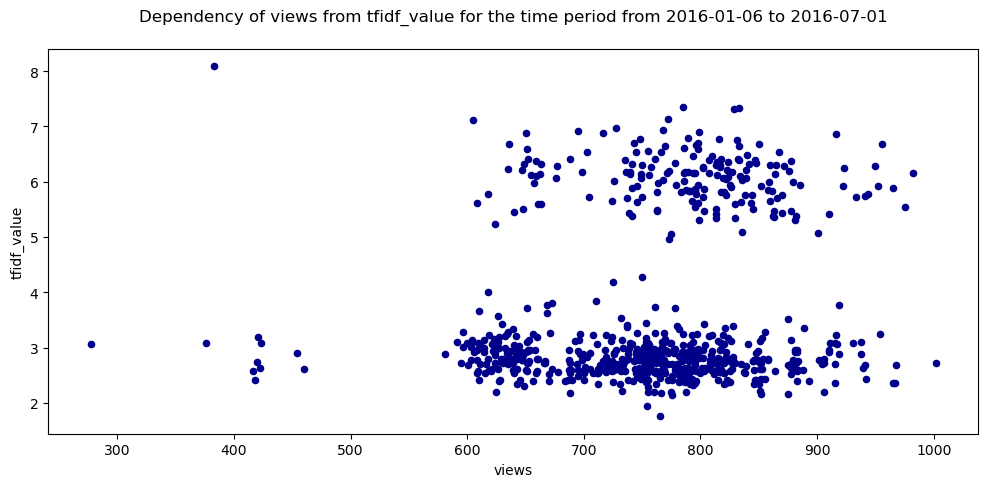

In [134]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2016-01-06 to 2016-07-01',y=1.05)
plt.show()

<span style="color:blue">We can clearly see 2 clasters in the data. Let's check examples of messages.</span>

In [137]:
# Upper cluster
df[(df['tfidf_value'] > 5) & (df['views'] > 800)].iloc[0]['message']

'💥 С концом рабочей недели! Ловите нашу вечернюю новостную подборку:\n\nВвоз в РФ ряда европейских продуктов ограничен из-за ГМО https://russian.rt.com/article/303672-rosselhoznadzor-ogranichil-vvoz-ryada-evropeiskih-produktov-iz\n\n🇺🇦 В украинском Тернополе запретили песни в исполнении журналистов, Охлобыстина и Депардье https://russian.rt.com/article/303666-vlasti-ternopolya-zapretili-slushat-pesni-boyarskogo-i\n \nПентагон по-прежнему не намерен координировать действия в Сирии с Россией https://russian.rt.com/article/303675-pentagon-ssha-ne-budut-koordinirovat-operacii-v\n\nДональд Трамп собирается «по-взрослому охотиться за ИГ» https://russian.rt.com/article/303650-donald-tramp-sobiraetsya-borotsya-s-ig-a\n\nВидео о том, как семья из Ухты спасла оголодавшего медвежонка 🐻 https://russian.rt.com/article/303690-semya-iz-uhty-spasla-ogolodavshego-medvezhonka\n\nМарин Ле Пен в эксклюзивном интервью RT рассказала о протестах в Париже, перспективах развития Европы и признании российского 

In [144]:
# Lower cluster
df[(df['tfidf_value'] < 4 ) & (df['views'] > 750)].iloc[2]['message']

'Эсминец ВМС США USS Donald Cook находится в Балтийском море для оказания военного давления на Россию — постпред РФ при НАТО https://russian.rt.com/article/159672'

### Posts with the most views

In [148]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

🇺🇦 После реформ Украину будут просить вступить в ЕС вместо Британии — Саакашвили https://russian.rt.com/article/309327-mihail-saakashvili-posle-reform-ukrainu-budut-prosit


### The most important messages

In [108]:
print(df.iloc[0]['message'])

Камрады, у кого есть facebook

Время собирать людей в одном месте. Чтобы пусть изредка, но мы там пересекались и могли общаться. Поэтому мне нужна от вас поддержка КМ - Культурного минимума:

https://www.facebook.com/groups/kultminimum/

Если с ФБ не работаете, есть ВК: https://vk.com/kultminimum

Я принципиально не хочу никакого платного продвижения для группы, в ней нужны только реальные люди. Помоек с десятками и сотнями тысяч ботов хватает и без нас.

Действовать сомнительными методами, публикуя в ЖЖ часть поста и вынуждать вас дочитывать его в группе, согласитесь, еще хуже, это неуважение.

Поэтому, как впрочем и всегда, говорю прямо - мне нужны там вы, ваши друзья, коллеги и родственники. Если вы готовы не просто вступить в группу, но и рассказать о ней своему окружению, в том же фейсбуке, еще лучше.

После того, как группа наберет весомую численность, состоящую из реальных, подчеркиваю, людей, мы с ребятами приступим к реализации второго этапа, который, поверьте, будет очень инт

https://ura.news/news/1052536835
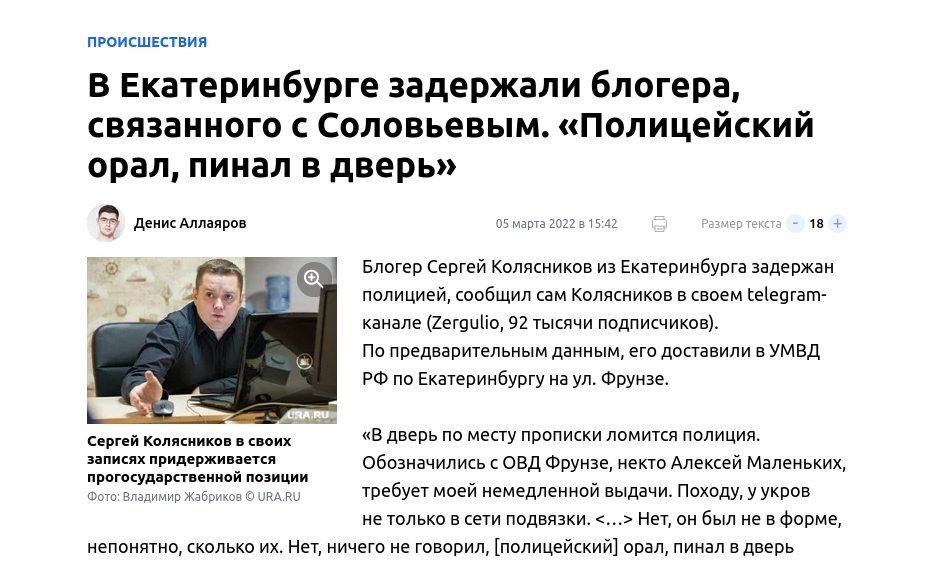

In [123]:
print(df.iloc[1]['message'])

Конец рабочей недели совсем близко! Ваша новостная подборка на этот вечер 🌠:

Беспилотник, еда, дом: насколько далеко продвинулась 3D-печать? https://russian.rt.com/article/305753-uznat-za-60-sekund-chto-uzhe-seichas

Забавное видео, как житель Техаса оплатил штраф в $212 монетами по одному центу в отместку суду💰 https://russian.rt.com/article/305772-zhitel-tehasa-oplatil-shtraf-v-212-monetami

В Париже закроют метро и Лувр из-за наводнения https://russian.rt.com/article/305767-v-parizhe-mogut-zakryt-metro-i-luvr

МРОТ с 1 июля повысится до 7,5 тыс. рублей ⬆️https://russian.rt.com/article/305747-vladimir-putin-podpisal-zakon-o-povyshenii-mrot

Более 250 тыс. граждан Латвии лишены гражданских прав — Мария Захарова https://russian.rt.com/article/305742-mariya-zaharova-bolee-250-tys-grazhdan-latvii

Немецкие СМИ сообщили о бешенстве Савченко из-за возможного снятия санкций с РФ 🙀 https://russian.rt.com/article/305685-smi-savchenko-v-beshenstve-ot-predlozhenii-snyat

👊🏼 Видео драки Спанч Б

# 2 From 2016-07-06 to 2017-01-01 the dataset has 1541 messages

In [306]:
period = periods_list_2[1]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2016-07-06 to 2017-01-01 the dataset has 1541 messages


In [307]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_1 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_1)

words corpus 1541
[0.27, 0.19, 0.2, 0.07, 0, 0, 0, 0.22, 0.14, 0.1, 0.14, 0.06, 0.14, 0.43, 0.11, 0, 0.25, 0.15]


In [159]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

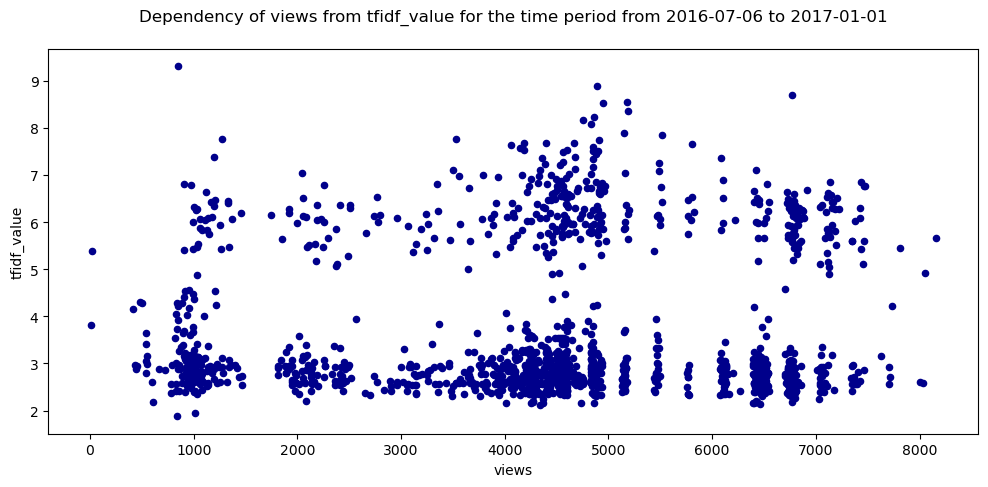

In [152]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2016-07-06 to 2017-01-01',y=1.05)
plt.show()

In [160]:
# Upper cluster
df[(df['tfidf_value'] > 5) & (df['views'] > 7000)].iloc[0]['message']

'☁️ Доброе утро, друзья! Всё самое интересное — читайте ниже:\n\n📺 Дебаты для народа: Общественная палата просит час эфирного времени на федеральных каналах http://ru.rt.com/79pt\n\n🇺🇦 Дмитрий Бабич о компромате Онищенко на Порошенко http://ru.rt.com/79pn\n\n❓ Спорная классика: «Гекльберри Фин» исключен из школьной программы США за расизм http://ru.rt.com/79p3\n\n🇪🇺🇮🇹Сапогом на выход: ЕС рискует потерять Италию после неудачного для левых референдума http://ru.rt.com/79pj\n\n💻 На страже интересов: основные положения новой Доктрины информационной безопасности России http://ru.rt.com/79pc\n\n🇹🇷 Эрдоган подписал закон о ратификации соглашения с Россией по «Турецкому потоку» http://ru.rt.com/79p2\n\nХорошего дня 👋🏼'

In [156]:
# Lower cluster
df[(df['tfidf_value'] < 4 ) & (df['views'] < 4000)].iloc[0]['message']

'Мариани отказался отвечать журналисту УНИАН на его «д*****вые вопросы» 🔥\nПредставитель СМИ обвинил главу делегации французских парламентариев в Крыму в подкупе со стороны России \nСмотрите видео➡️https://russian.rt.com/article/314878-u-lyudei-byvayut-ubezhdeniya-a-ne-tolko'

### Posts with the most views

In [161]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

Здравствуйте, друзья! События этого дня — в нашей подборке:

«Мы вместе вывозили раненых детей»: корреспондент RT о работе с Доктором Лизой в Донбассе https://ru.rt.com/7e7f

«Ужасно, страшно, не поддаётся описанию»: коллеги о гибели артистов ансамбля Александрова https://ru.rt.com/7e5l

Мацуев о трагедии Ту-154: «У меня внутри — боль» https://ru.rt.com/7e76

Илья Резник о гибели артистов ансамбля имени Александрова: мы их потеряли, это страшно https://ru.rt.com/7e5d

Рогозин назвал советника Порошенко «моральным уродом» после его высказывания о Ту-154 https://ru.rt.com/7e88

До завтра!


### The most important messages

In [116]:
print(df.iloc[0]['message'])

Про эксгибиционизм

У нас как "сверху" видят какое то стремление людей - тут же организуется тьма тьмущая поганок, которые как в анекдоте, про "Россию - Родину слонов", тут же "берут направление под контроль".

На самом деле они не под контроль берут, а пилят бюджеты и дискредитируют, после чего, в большинстве случаев, тема гибнет.

Сейчас такой темой стал патриотизм. Столько развелось - на улице уже окурок не выбросить, из кустов тут же "ой, тут у нас мегасуперпатриотцентр", не плюйтесь пожалуйста, а лучше присоединяйтесь, вот наш флажок для демонстрации и дайте денег. Отличить такие организации и отдельных паразитов от патриотики очень легко по риторике - они самые патриоты, а все остальные продажное г*вно, это сквозит у них у всех, потому что денег надо давать только им, они лучшие.

Думаю, может нам про эксгибиционизм писать чаще? Ну вот мол, течение такое, интересно, давайте все туда.

Единая Россия тут же откроет федеральную сеть "Юные эксгибиционисты", Зюганов признается, что да

In [117]:
print(df.iloc[1]['message'])

👋🏼Хорошего вечера! Читайте нашу подборку, мы не дадим вам пропустить важные новости уходящего дня:

⚡️В Европарламенте одобрили проект резолюции о контрпропаганде в отношении стран. В частности, в документе утверждается, что Россия ведёт информационную войну против Евросоюза https://russian.rt.com/article/325376

🇺🇸Американские власти обвиняют Россию 🇷🇺 в военных преступлениях в Сирии🇸🇾, хотя США в ходе своих операций неоднократно применяли запрещенные боеприпасы. О белом фосфоре и кассетных бомбах — в нашем материале ➡️https://russian.rt.com/article/325392 

🔹Эстонские парламентарии рассказали, почему обещание нового президента страны говорить по-русски ничего не значит https://russian.rt.com/article/325350

🔹Экс-глава ОКР Тягачёв в интервью RT — о кризисе в российском спорте, новом WADA и спортивных успехах Путина https://russian.rt.com/article/325367

🔹Вокруг нефти и газа: как развивается спор между Москвой и Минском https://russian.rt.com/article/325363

🔹Валерий Гергиев — о концер

# 3 From 2017-01-01 to 2017-07-01 the dataset has 12093 messages

In [178]:
period = periods_list_2[2]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2017-01-01 to 2017-07-01 the dataset has 12093 messages


In [179]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_2 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_2)

words corpus 12093
[0.05, 0.19, 0.19, 0.05, 0, 0, 0.25, 0.1, 0.18, 0.13, 0.31, 0.04, 0.18, 0, 0.22, 0.1, 0.06, 0.44]


In [180]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

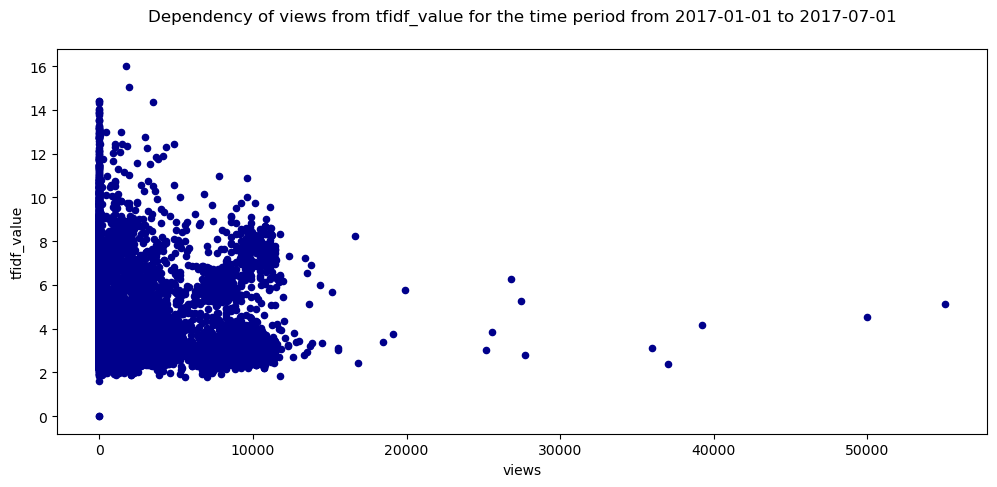

In [181]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2017-01-01 to 2017-07-01',y=1.05)
plt.show()

### Posts with the most views

In [182]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

⚡️Полиция задержала участника протестной акции в Москве, который распылил перцовый газ в лицо сотруднику ОМОНа. В его отношении будет заведено уголовное дело. Возможно, оно будет объединено с делами тех, кто вырывал задерживаемых из рук ОМОН, бил их кулаками, а также юноши, который ударил ногой в голову упавлешего сотрудника Росгвардии


### The most important messages

In [168]:
print(df.iloc[0]['message'])

Как Сирия с Ираком помогли осознать "Русскую весну"

Мы сидели в огромном шатре на иракской базе Кайара к югу от Мосула. Большие промышленные кондиционеры гоняли по палатке коктейль из запахов жареной курицы, кальяна с табаком «двойное яблоко» и плохо постиранных носков (это арабские журналисты кашеварили что-то прямо здесь, на газовой плитке). Мы сидели в своем уголке, отгороженном раскладушками, пытаясь поймать Internet happy hour. В определенное время суток скорость Сети возрастала с отметки безобразная до уровня средней паршивости. Отложив все дела (стирка, чистка обуви, душ) мы перегонялись в редакцию.
- Глядите, я вам еще русских привел! - довольно доложил знакомый иракский боец, ведя за собой двоих европейцев.
Одного я узнал сразу.
- Привет, я Горан, - сказал он по-английски.
- Привет, я знаю, - машинально ответил я, протянув руку.
- Странное имя, - засмеялся Горан. Он наверно привык, что его узнают.
Перед нами стояла легенда мировой военной журналистики. Горан Томашевич, фотогр

# 4 From 2017-07-01 to 2018-01-01 the dataset has 25270 messages

In [192]:
period = periods_list_2[3]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2017-07-01 to 2018-01-01 the dataset has 25270 messages


In [193]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_3 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_3)

words corpus 25270
[0.03, 0.06, 0.03, 0.05, 0, 0, 0.25, 0.21, 0.31, 0.03, 0.32, 0.04, 0.09, 0.34, 0.08, 0.07, 0.05, 0.3]


In [194]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

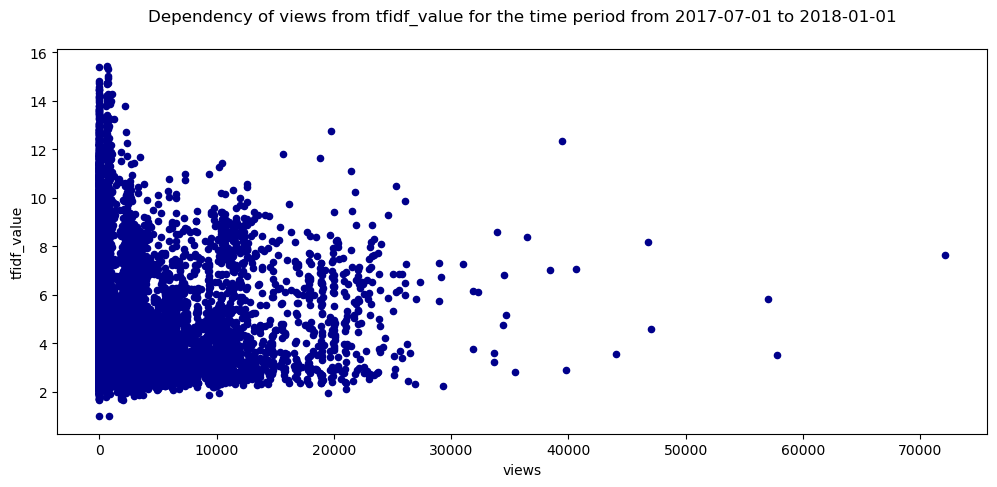

In [195]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2017-07-01 to 2018-01-01',y=1.05)
plt.show()

### Posts with the most views

In [187]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

🔥🔥🔥Привет. А  мы, как и обещали, публикуем разговор с Ильей Варламовым. Так как диалог у нас получился большой, текст разбит на две части. 


В первой части читатели узнают, сколько денег Илья делает на соцсетях, как «околокремлёвские» структуры пытались отправить его в Лондон, чтобы он не снимал Болотную, в чем он не согласен с Кашиным насчет прогресса в развитии журналистики. Как прогнулись Инстаграмм и Фейсбук перед Госдепом и заблокировали аккаунты Кадырова. Какое будущее видит Варламов для книжной секты Васи Якеменко и почему не стоит пиариться на имени самого Варламова в судах. 
http://telegra.ph/Razgovor-s-Ilej-Varlamovym-12-26 

Во второй части вы прочтете, почему выборы на взгляд Варламова профанация и что в этой связи население вправе требовать от власти, а что нет. О том, насколько Россия отстала в устройстве городов от остального мира, что хорошего в Реновации. Про таксу Рогозина и почему Варламов не взялся бы строить город будущего, даже если бы его хорошо об этом попросил

### The most important messages

In [188]:
print(df.iloc[0]['message'])

«Все, взявшие меч, мечом погибнут» (Мф. 26, 52)

Это пророчество Спасителя обращаем Мы к вам, нынешние вершители судеб нашего отечества, называющие себя «народными» комиссарами. Целый год держите в руках своих государственную власть и уже собираетесь праздновать годовщину Октябрьской революции. Но реками пролитая кровь братьев наших, безжалостно убитых по вашему призыву, вопиет к небу и вынуждает нас сказать вам горькое слово правды.

Захватывая власть и призывая народ довериться вам, какие обещания давали вы ему и как исполнили эти обещания?
Поистине, вы дали ему камень вместо хлеба и змею вместо рыбы (Мф. 7, 9 - 10). Народу, изнуренному кровопролитной войною, вы обещали дать мир «без аннексий и контрибуций».

*

От каких завоеваний могли отказаться вы, приведшие Россию к позорному миру, унизительные условия которого даже вы сами не решались обнародовать полностью? Вместо аннексий и контрибуций великая наша Родина завоевана, умалена, расчленена, и в уплату наложенной на нее дани вы та

# 5 From 2018-01-01 to 2018-07-01 the dataset has 25270 messages

In [196]:
period = periods_list_2[4]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2018-01-01 to 2018-07-01 the dataset has 34945 messages


In [197]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_4 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_4)

words corpus 34945
[0.04, 0.08, 0.18, 0.06, 0, 0, 0.15, 0.06, 0.17, 0.07, 0.29, 0.09, 0.08, 0, 0.23, 0.09, 0.13, 0.11]


In [198]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

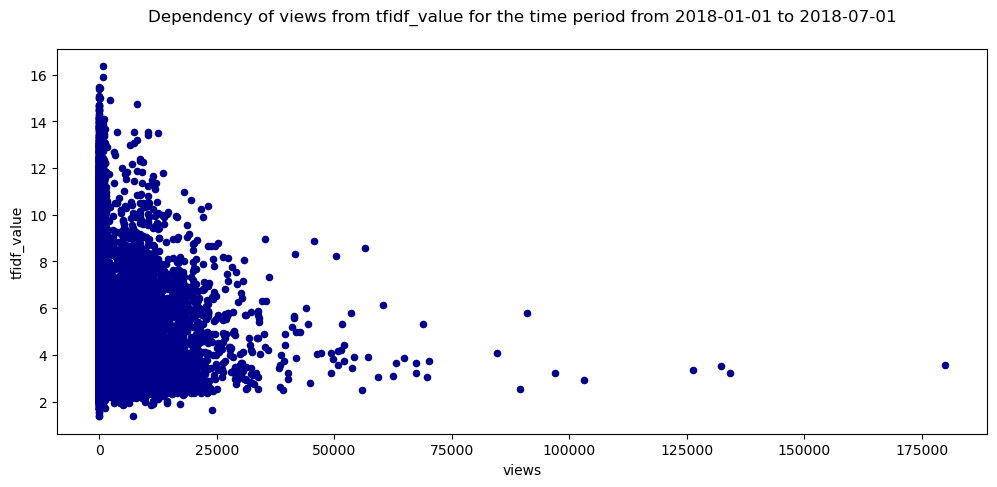

In [199]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2018-01-01 to 2018-07-01',y=1.05)
plt.show()

### Posts with the most views

In [200]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

Французы обиделись на пантомиму Трампа. Он показал, как убивали людей в Батаклане в 2015. Трамп проповедовал обычную мантру, что если бы в зале были парни с оружием, то всё закончилось бы по-другому🤔


### The most important messages

In [201]:
print(df.iloc[0]['message'])

Основной момент, который бросился в глаза сугубо визуально – почти нет мужиков моего возраста, т.е. 35-40 лет. Даже в дни праздников колобродят в основном либо бухие малолетки, либо дяди пред- и пенсионного возраста. Мои ровесники, как понимаю, поуезжали на заработки. Повторяю, это чисто на взгляд со стороны, без статистики.

Язык

Языковое поле с моих времён повернулось на 180 градусов, то есть теперь 90% населения говорит на украинском. При этом (особенно продавцы) мгновенно переходят на чистый русский, если ты говоришь на нём.

Такси и авто

Как я уже писал про вокзал – поражает количество такси. Город таксистов. Вызывать машину нужно уже одевшись и обувшись потому, что пока вы спуститесь к подъезду, машина уже будет стоять. Время подачи реально минута-две. Таксуют все!
Автопарк поражает количеством корчей и корыт. Я такой выставки автохлама, вроде Lanos в различной степени гниения, старых VW начала 90-ых и их аналогов в России не видел нигде. Даже в Орле количество бюджетных тачек,

# 6 From 2018-07-01 to 2019-01-01 the dataset has 25270 messages

In [202]:
period = periods_list_2[5]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2018-07-01 to 2019-01-01 the dataset has 45989 messages


In [203]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_5 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_5)

words corpus 45989
[0.05, 0.26, 0.11, 0.11, 0, 0.06, 0.35, 0.04, 0.32, 0.07, 0.11, 0.11, 0.13, 0.17, 0.06, 0.18, 0.2, 0.21]


In [204]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

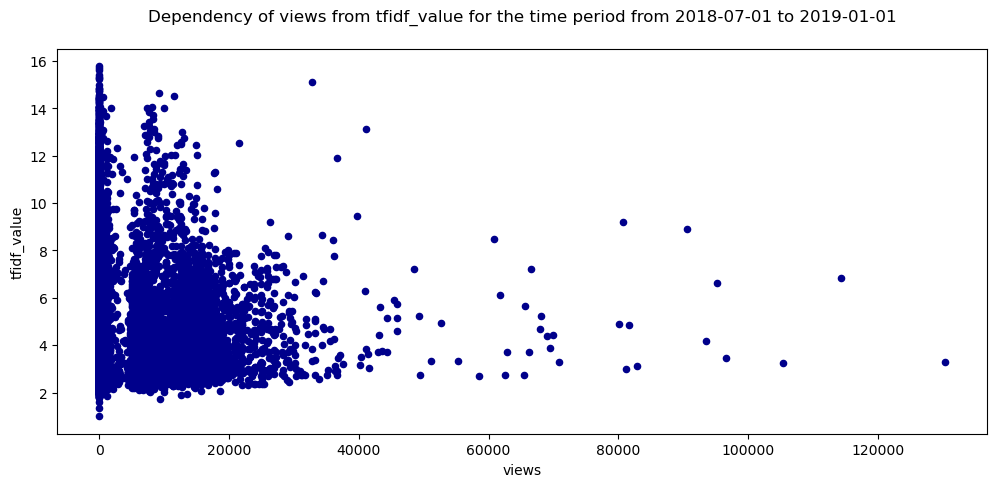

In [205]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2018-07-01 to 2019-01-01',y=1.05)
plt.show()

### Posts with the most views

In [206]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

💥Крымский кризис. Полное видео тарана сторожевиком ФСБ украинского буксира у берегов Крыма.
ВНИМАНИЕ, 18+ (много мата)


### The most important messages

In [207]:
print(df.iloc[0]['message'])

А помните, была такая пенсионная реформа? Чем закончились попытки сконвертировать миллионы подписей в интернете во что-то оффлайновое? Все верно — очередной итерацией сказки про курочку и яички.

Яичек в итоге не нашлось ни у КПРФ, так и не пришедших в себя после грудининского провала, ни у Навального, который ради попыток соорудить из пенсионеров баррикады забил на оседланную было свободу интернета. Бабье лето из последних сил давало возможности, но в минувшую субботу их окно можно считать окончательно закрытым. 

Ну под тысячу собралось в Барнауле, Самаре и Астрахани, но остальные города, миллионники где? В Питере, в ясную солнечную погоду, протестовать вышло всего 300 человек. Куда слили протест? Известно куда, но, объективности ради, дело здесь не только в самом протесте, но и в стратегии поведения, выбранной властью.

Уничтожить оппозицию не получилось ни барабанами на площадях, ни заигрыванием с ней, ни с помощью админресурса или закручивания законодательных гаек. Не эта, так дру

# 7 From 2019-01-01 to 2019-07-01 the dataset has 25270 messages

In [208]:
period = periods_list_2[6]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2019-01-01 to 2019-07-01 the dataset has 51461 messages


In [209]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_6 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_6)

words corpus 51461
[0.19, 0.21, 0.06, 0.05, 0, 0, 0.11, 0.12, 0.18, 0.06, 0.31, 0.07, 0.25, 0.07, 0.09, 0.13, 0.24, 0.1]


In [210]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

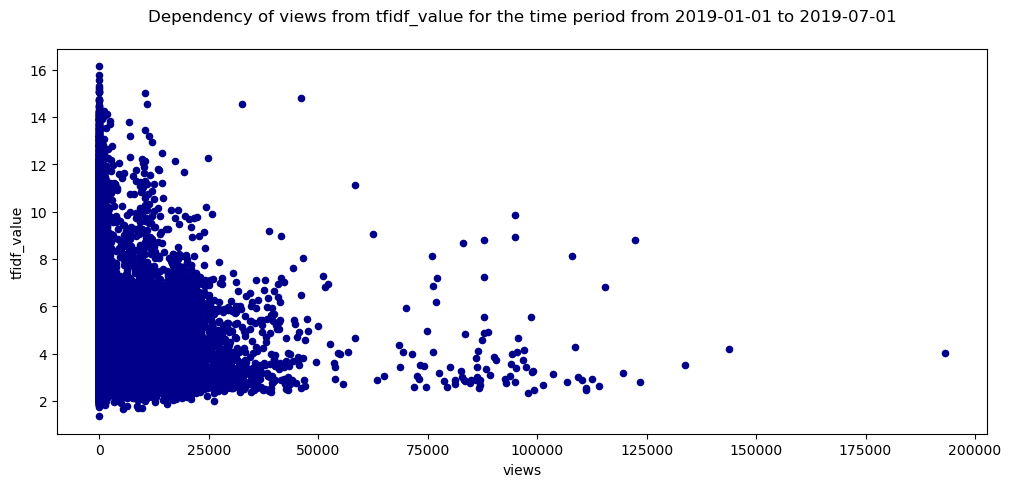

In [211]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2019-01-01 to 2019-07-01',y=1.05)
plt.show()

### Posts with the most views

In [212]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

Владимир Путин выстрелил из пушки во время рождественских гуляний в Петропавловской крепости.

Вместе с ним из Д-30 совершил выстрел почётный строитель России Владимир Львович Бендет, которому 7 января исполнилось 85 лет


### The most important messages

In [213]:
print(df.iloc[0]['message'])

Когда стоишь на пороге смерти, гораздо острее чувствуешь вкус жизни. Один из способов ощутить это всей лимбической системой - лишить себя еды, тепла и привычного комфорта.

Такая мобилизация действительно очищает разум от ежедневной рутины. Встряска заставляет по-новому взглянуть на привычные вещи и бодрит, если происходит кратковременно. Иначе (как любой стимуляцией) ей очень легко увлечься и подорвать здоровье.

В отличие от Сергея Фаге, Павел Дуров не биохакер. Скорее, он сторонник ЗОЖ, и в этом смысле не делает ничего из ряд вон выходящего. Просто пробует разные практики из веганства, голодания и экстремального закаливания. Мечется от Пола Брэгга до Порфирия Иванова. 

Все эти практики известны давно, как и их результаты. Сравнительно молодой и крепкий организм Павла пока прощает некоторые перегибы, а вот его последователи могут заработать ряд серьёзных осложнений потому, что уже имеют разные функциональные нарушения, а то и хронические заболевания.

Универсальных рекомендаций вооб

# 8 From 2019-07-01 to 2020-01-01 the dataset has 79076 messages

In [216]:
period = periods_list_2[7]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2019-07-01 to 2020-01-01 the dataset has 79076 messages


In [217]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_7 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_7)

words corpus 79076
[0.09, 0.05, 0.07, 0.11, 0, 0.32, 0.16, 0.06, 0.09, 0.12, 0.27, 0.04, 0.06, 0.09, 0.06, 0.12, 0.13, 0.13]


In [218]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

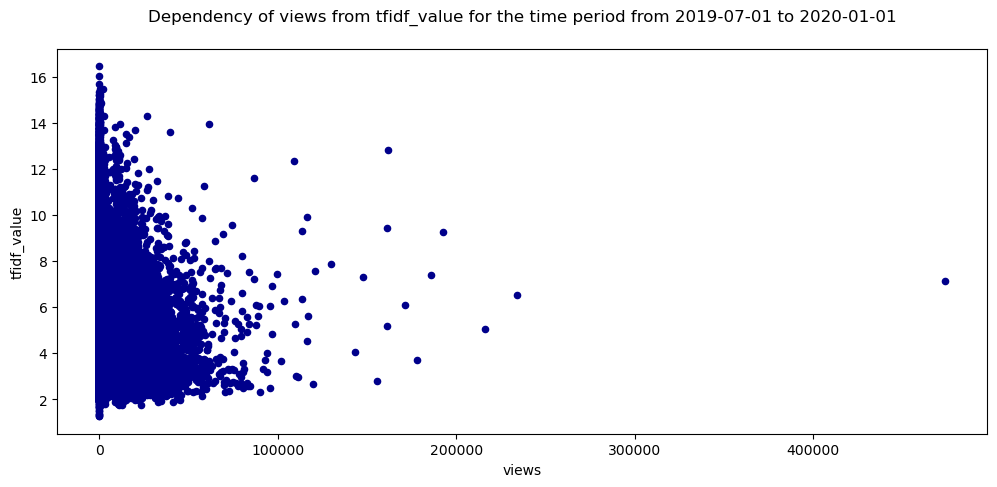

In [219]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2019-07-01 to 2020-01-01',y=1.05)
plt.show()

### Posts with the most views

In [220]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

По данным RT, стрельба в приёмной ФСБ в Москве на улице Кузнецкий Мост, 23 произошла в 18:10.

По одной из версий, трое неизвестных ворвались в здание приёмной ФСБ, где и открыли стрельбу. По другой версии - войти в приёмную им не удалось, и стрельба началась у парковки, расположенной возле. В перестрелке с охраной приёмной двое нападавших были убиты. Один из нападавших выбежал на улицу, где продолжил стрелять. В результате был убит сотрудник ГИБДД, дежуривший напротив здания приёмной.

Нападавшему удалось пробежать около 300 метров: он добежал до конца улицы Кузнецкий Мост, завернул на площадь Воровского, периодически отстреливаясь. Двинулся по улице Большая Лубянка, где забаррикадировался в одном из помещений дома №2. Оттуда он периодически вёл огонь по прибывшим бойцам ЦСН ФСБ и ОМОНа. В ходе перестрелки в 19:15 преступник был убит. По данным ФСБ РФ, личности убитых устанавливаются.

По предварительным данным, спецслужбы квалифицируют данное происшествие как теракт


### The most important messages

In [222]:
print(df.iloc[1]['message'])

Впечатления Евгения Мефёдова о Москве после "почти эуропейской" страны

Около трёх месяцев прошло с моего возвращения на Родину. Великое множество впечатлений и эмоций за всё это время. Москву еле узнал. Этими небольшими наблюдениями и хочу с вами поделиться, пропустив геополитические козни и интриги против нашей страны. О политике писать и вовсе не хочется, пускай этим занимаются другие...

Первое, что бросилось в глаза, чистота улиц. Возможно я просто отвык от работы коммунальных служб как таковых, проживая в соседней, "вот-вот уже почти эуропейской" стране.

Пробки конечно остались, но их теперь намного меньше. Появились-таки новые развязки, многие улочки превратились в широкополосные дороги отличного качества. Такой долгострой, например, как алабяно-балтийский туннель, наконец-то завершён, сильно разгружая стык Волоколамского и Ленинградского шоссе. А сама Большая Академическая расширилась вдвое, увеличив тем самым свою пропускную способность. Достроили и дублёр Можайского шоссе, с

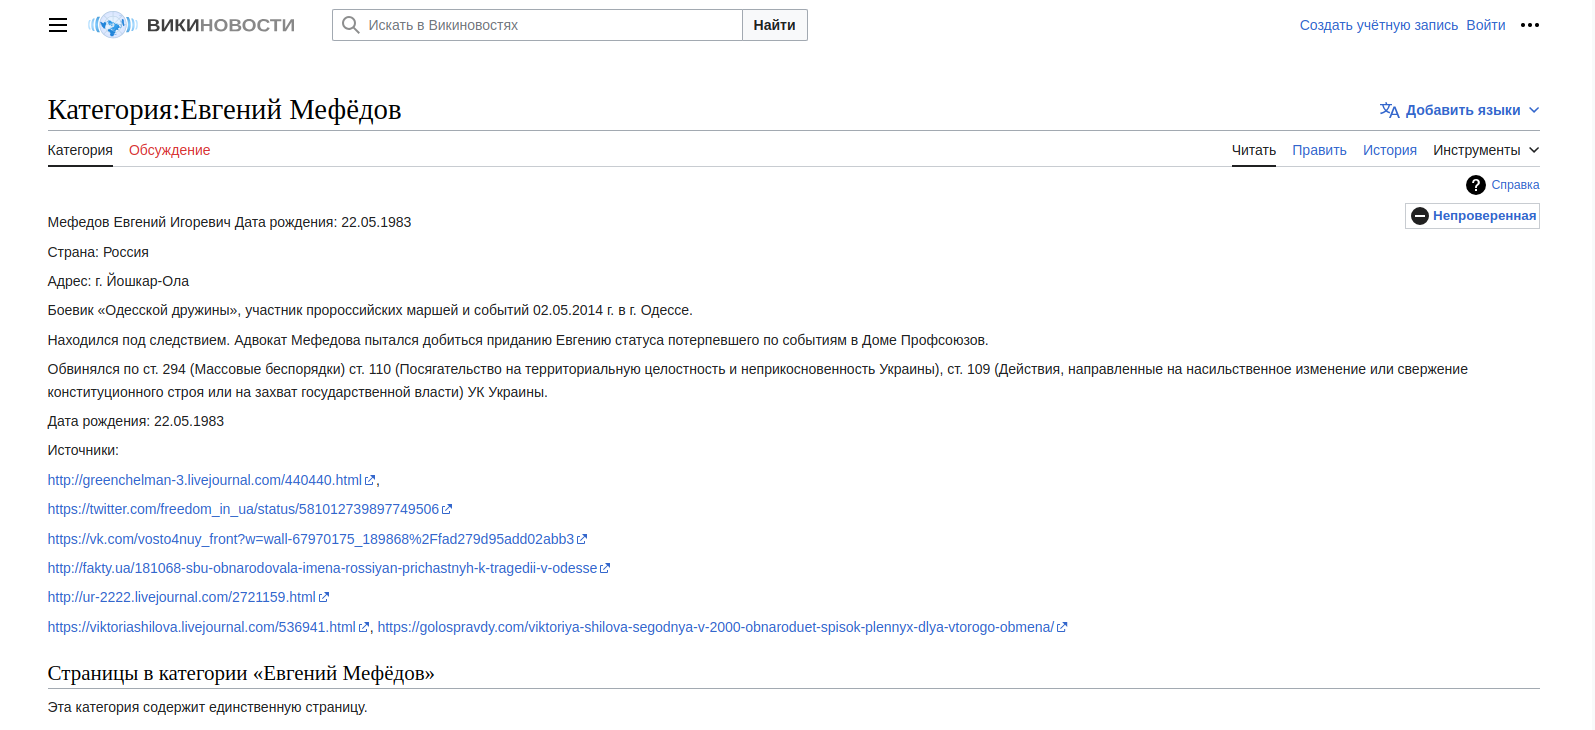

# 9 From 2020-01-01 to 2020-07-01 the dataset has 125018 messages

In [223]:
period = periods_list_2[8]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2020-01-01 to 2020-07-01 the dataset has 125018 messages


In [224]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_8 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_8)

words corpus 125018
[0.05, 0.16, 0.1, 0.08, 0.03, 0.07, 0.17, 0.05, 0.05, 0.15, 0.1, 0.1, 0.16, 0.19, 0.11, 0.08, 0.06, 0.06]


In [225]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

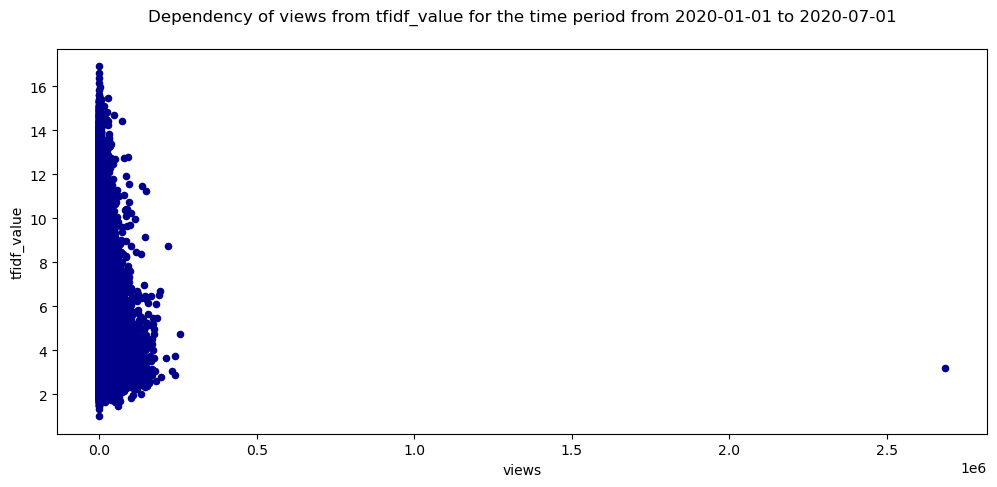

In [226]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2020-01-01 to 2020-07-01',y=1.05)
plt.show()

### Posts with the most views

In [227]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

Потребление кофе в России в 2019 году достигло 180 тыс. тонн и впервые превысило потребление чая, говорится в материалах Российской ассоциации производителей чая и кофе "Росчайкофе".


### The most important messages

In [230]:
print(df.iloc[1]['message'])

…Однажды Россия взяла да исчезла

Ну, в общем, так случилось. Туман сошёл в стиле Стивена Кинга или вдруг улетела куда-то. Бывает, короче говоря. Кто мог предположить ещё полгода назад, что мы станем сидеть месяцами на карантине? Вот и тут – Россия пропала неведомым образом. Без объяснений и любой официальной информации.

…В Соединённых Штатах политики оцепенели от ужаса. Журналисты CNN сломали двери в аптеках, скупая успокоительное ящиками. Ведь если президент Дональд Трамп снова победит на выборах, кого же тогда обвинять во вмешательстве? России-то больше нет. Северная Корея с полудохлым интернетом и уевшимися кимчи хакерами во враги не годилась. Дикторы на экранах молча шевелили ртом, как рыбы: стараясь заменить слово «Россия» в проклятиях за поддержку режимов Белоруссии, Венесуэлы и Сирии. Не получалось. Теперь подлые режимы, возмущая свободный мир, держались сами по себе. The New York Times, желая исправить ситуацию, обвинила в манипуляциях со смертностью от COVID-19 Кубу. Это ник

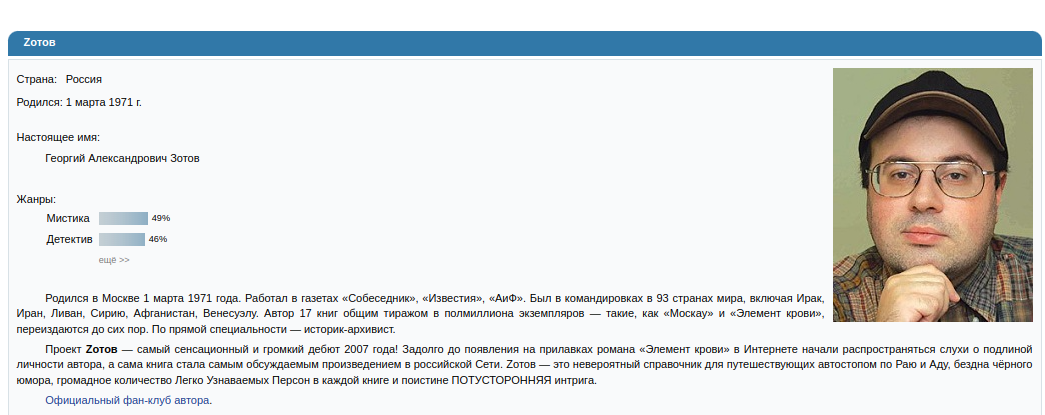

# 10 From 2020-07-01 to 2021-01-01 the dataset has 126755 messages

In [231]:
period = periods_list_2[9]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2020-07-01 to 2021-01-01 the dataset has 126755 messages


In [232]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_9 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_9)

words corpus 126755
[0.08, 0.22, 0.12, 0.06, 0.09, 0.39, 0.2, 0.05, 0.04, 0.04, 0.09, 0.03, 0.08, 0.06, 0.12, 0.07, 0.08, 0.1]


In [233]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

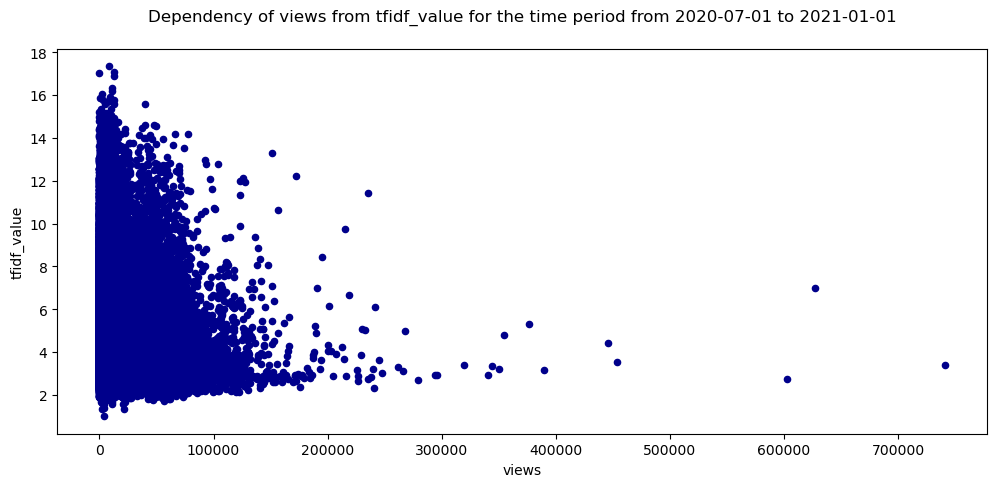

In [234]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2020-07-01 to 2021-01-01',y=1.05)
plt.show()

### Posts with the most views

In [235]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

Десять БТР находятся у Дворца Независимости в Минске, где сегодня ожидаются акции протеста, передает корреспондент РИА Новости


### The most important messages

In [244]:
print(df.iloc[8]['message'])

Юлия Витязева: Либеральные методички в США и России одинаковые

Если вы хотите посмотреть, как выглядит настоящая демократия изнутри, то вы, наверняка, захотите посетить Соединённые Штаты Америки. Ведь всем известно, что именно там находится колыбель всяческих свобод и прочих идеальных социальных институтов, коих так не хватает вечно стенающим о диктатуре российским либералам. 

Потому мы сегодня отправимся на экскурсию в американский город Портленд, где уже 50-й день не утихают протесты BLM, которые давно уже перешли в стадию погромов и держат в страхе все адекватное население города и его окрестностей. 

При этом, мэр Портленда всячески приветствует вечеринки с мордобоем, использованием пиротехники в адрес местной полиции и набеги на ещё уцелевшие магазины. Однако, в Вашингтоне решили, что поминки Джорджа Флойда слишком затянулись и начали принимать радикальные меры по наведению порядка.

А так как местная полиция окончательно измотана и деморализована, то за дело взялись федералы. И

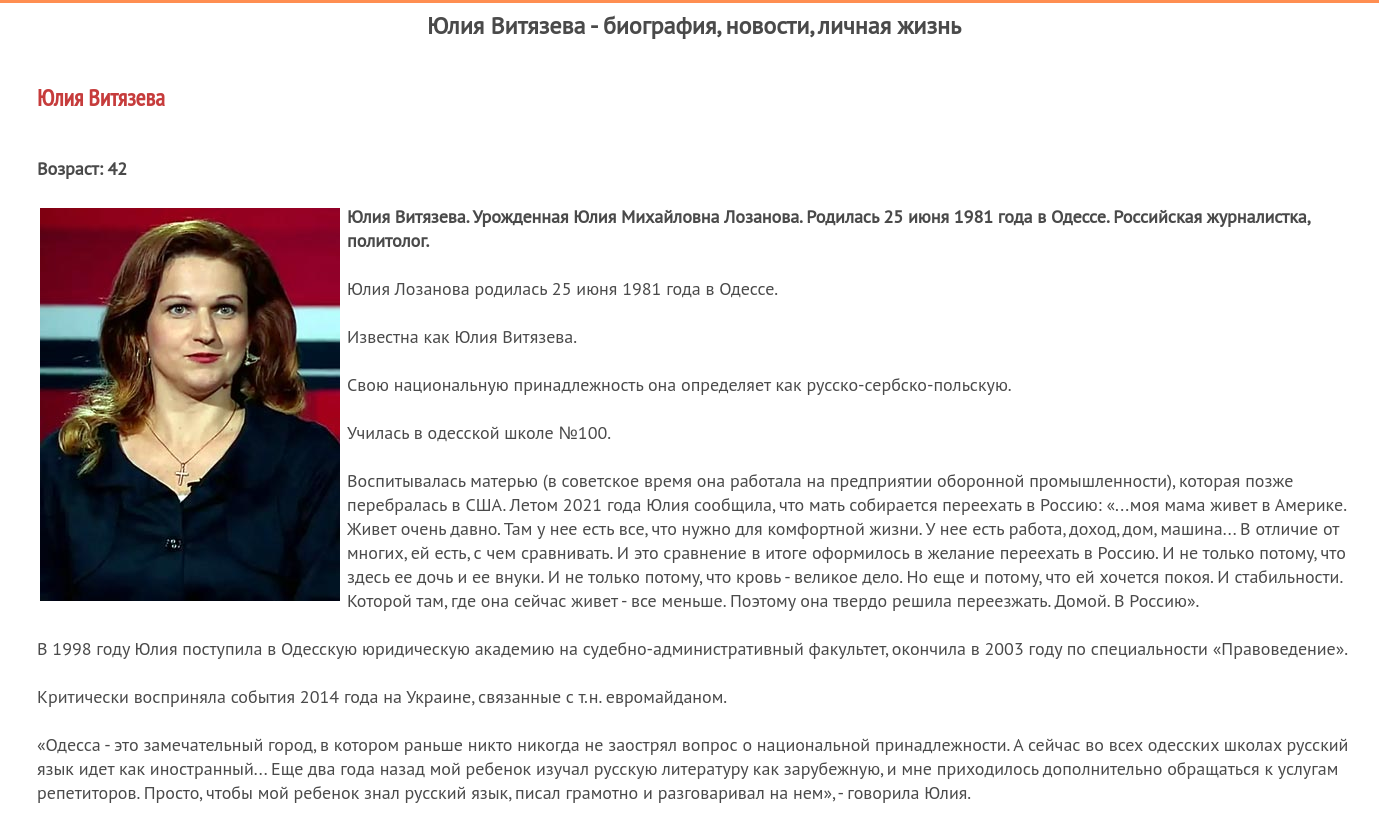

# 11 From 2021-01-01 to 2021-07-01 the dataset has 129841 messages

In [245]:
period = periods_list_2[10]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2021-01-01 to 2021-07-01 the dataset has 129841 messages


In [246]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_10 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_10)

words corpus 129841
[0.14, 0.07, 0.1, 0.25, 0.14, 0.2, 0.38, 0.12, 0.24, 0.03, 0.18, 0.03, 0.06, 0.22, 0.1, 0.22, 0.09, 0.09]


In [247]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

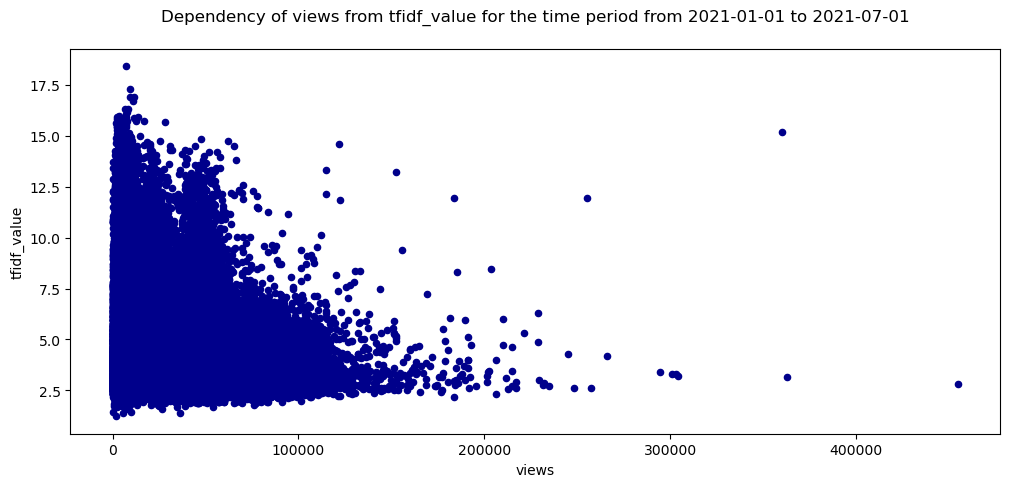

In [248]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2021-01-01 to 2021-07-01',y=1.05)
plt.show()

### Posts with the most views

In [249]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

Оператор "Северного потока 2" предоставил еще фото кораблей, мешающих прокладке газопровода


### The most important messages

In [256]:
print(df.iloc[6]['message'])

Враг у ворот - 2 🔥
По последним гендерным стандартам Голливуда

В свете вакханалии всеобщей политкорректности, новой визии прошлого автокефальными и соборными историками всех ориентаций и последних гендерно - расовых требований к художественным фильмам, становится просто страшно - что цивилизованный мир и его адепты на постсоветском пространстве могут снять о Великой Отечественной войне.

Думаю, "Враг у ворот" - вышедший из-под смеси задержки в умственном развитии, альтернативной истории, героина и дуста, покажется просто курсовой работой хронического второгодника сантехнического ПТУ.

Так вот. Картина 3D - маслом.

--------------

Начальник Генерального штаба РККА генерал армии Гергий Жуков  (белый актер, мужчина) приходит к товарищу Сталину (в исполнении афрогренландца - гея).

Товарищ Жуков смертельно устал от бремени осознания вины белого человека и хочет организовать коллективное покаяние высшего советского руководства на внеочередном пленуме Политбюро ЦК ВКП(б). 

Сталин, стремяс

<span style="color:blue">I bet Георгий Зотов wrote this text.</span>

# 12 From 2021-07-01 to 2022-01-01 the dataset has 129841 messages

In [257]:
period = periods_list_2[11]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2021-07-01 to 2022-01-01 the dataset has 131732 messages


In [258]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_11 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_11)

words corpus 131732
[0.04, 0.17, 0.21, 0.15, 0.09, 0.22, 0.18, 0.06, 0.27, 0.21, 0.35, 0.03, 0.09, 0.05, 0.19, 0.17, 0.17, 0.11]


In [259]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

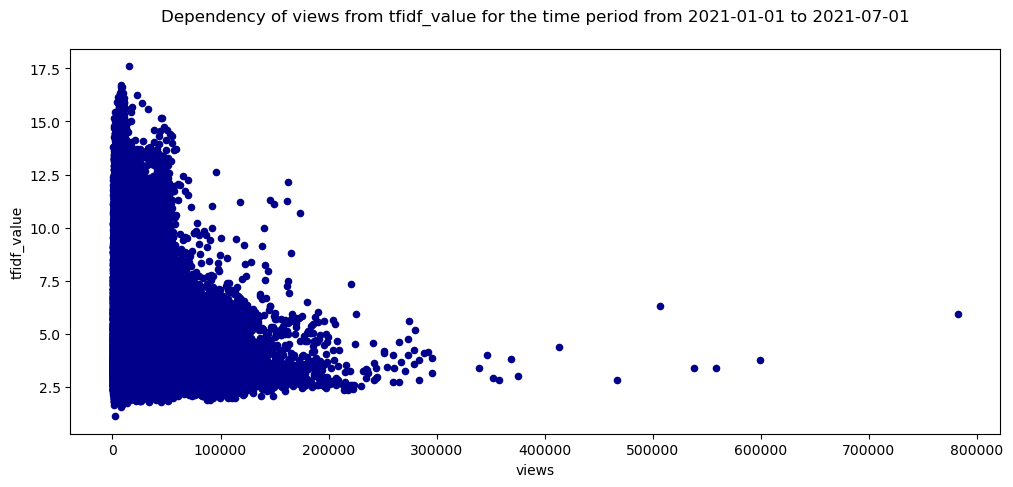

In [260]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2021-01-01 to 2021-07-01',y=1.05)
plt.show()

### Posts with the most views

In [261]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

Самые яркие роли Меньшова-актера:

• "Сказ про то, как царь Пётр арапа женил" (Меньшиков)
• "Где находится нофелет?" (Павел Голиков)
• "Куколка" (Вадим Николаевич)
• "Ширли-мырли" (президент России)
• "Диверсант" (Калязин)
• "Ночной дозор" (Гесер)
• "Легенда№17" (партработник Эдуард  Балашов)
• "Generation 'П' " (Фарсук Фарсейкин)
• "Ёлки-2" (Валерий  Гаврилов)
• "О чём ещё говорят мужчины" (Лев Толстой)


### The most important messages

In [263]:
print(df.iloc[1]['message'])

Мозаика. 15 сентября 2021 года

Елена Панина

США готовят новую кампанию по "промывке мозгов" жителям стран Восточной Европы, этим занимается USAID. Несмотря на то, что страны Восточной Европы уже тридцать лет находятся в поле интенсивного воздействия американской пропаганды, культурные отличия от Запада все еще очень велики. Многие до сих пор привержены традиционным ценностям, у значительной части населения сохранились симпатии к России.  

Телестрим

Рекордные цены на газ в Европе, поднявшиеся выше $800 за тысячу кубометров, уже заставляют власти некоторых стран ЕС принимать чрезвычайные меры по ограничению тарифов на газ и электроэнергию. В прошлом подобные всплески цен купировались переходом на конкурирующее топливо — уголь. Однако, как отмечают аналитики, в Западной Европе осталось слишком мало угольной генерации, чтобы эффект был значительным. 

Русский Демиург

Нынешняя Украина – это плод стечения обстоятельств. Изменятся обстоятельства – изменится Украина. Ни поражений, ни побе

# 13 From 2022-01-01 to 2022-07-01 the dataset has 167533 messages

In [264]:
period = periods_list_2[12]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2022-01-01 to 2022-07-01 the dataset has 167533 messages


In [265]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_12 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_12)

words corpus 167533
[0.16, 0.02, 0.13, 0.03, 0.12, 0.13, 0.11, 0.18, 0.22, 0.11, 0.26, 0.05, 0.05, 0.05, 0.11, 0.19, 0.07, 0.11]


In [266]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

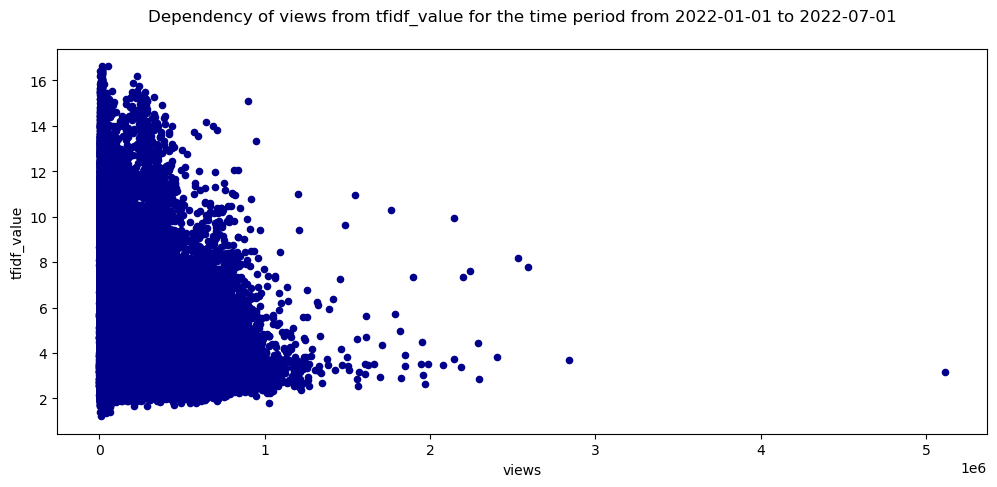

In [267]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2022-01-01 to 2022-07-01',y=1.05)
plt.show()

### Posts with the most views

In [268]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

📺Смотрите прямой эфир телеканала СоловьёвLive на удобной для себя платформе:

Telegram

Rutube

VK

Одноклассники

Rutube (24 часа)

Смотрим

🗣Или слушайте на СоловьёвFM


### The most important messages

In [269]:
print(df.iloc[0]['message'])

«Возвращение мирной жизни» — казённый штамп. Но иначе это коротко не описать. Еще в апреле, когда в Мариуполе стало спокойнее, первым знаком этого были торговцы и менялы — хлеб на редиску, таблетки на деньги. Уже зашла гуманитарная помощь и люди продавали ненужное, чтобы раздобыть более насущное. Вскоре открылся рынок, начали завозить продукты. В последних числах зацвела сирень — спустя неделю парни обломали все ветки выше человеческого роста — на букеты. Их подруги, улыбаясь, принимали цветы, брали кавалеров под руку. Таких пар, прогуливавшихся между полуразрушенных зданий  под звуки разрывов становилось с каждым днём всё больше. Они менялись. Когда стало легче с водой, девушки вымыли и распустили волосы, которые прятали прежде под платки и шапки. Одежда становилась всё чище, а потом и наряднее. 

В апреле любой, кто шёл по улицам Мариуполя, был чем-то занят — тащил тележку с баклажками воды, рюкзак с гуманитаркой, торопился встать в очередь. Прохожий тех дней обязательно озабочен, со

In [270]:
print(df.iloc[1]['message'])

Мозаика. 15 апреля 2022 года

Елена Панина

США и Европа без конца поднимают ставки в войне на Украине и все сильнее "тычут палкой в русского медведя". Об этом заявил скандально известный американский экономический прогнозист Мартин Армстронг. Если раскладки Армстронга верны, то уже весной-летом 2022 года конфликт на Украине может перерасти в прямое столкновение ВС РФ с подразделениями Альянса. Ответственность за которое целиком ложится на Запад.
 
Русский Демиург

Россия требует от США прекратить вооружать Украину, угрожая в противном случае "непредсказуемыми последствиями". Об этом говорится в официальной дипломатической ноте из Москвы.

Общественная служба новостей

В Конгрессе США высмеяли Байдена за попытку пожать руку невидимке. Действие охарактеризовали как «стыд» и призвали к импичменту. В МГУ отметили, что заявление не официальное, но подобные мнения в будущем будут расти.  

Новый Век

Кандидат в президенты Франции Ле Пен решила воспользоваться тем, что многие французы презир

# 14 From 2022-07-01 to 2023-01-01 the dataset has 135076 messages

In [271]:
period = periods_list_2[13]
from1 = period[0]
to1 = period[1]
df = top_channels_df[(top_channels_df['date_time']>from1) & (top_channels_df['date_time']<to1)]
print("From", from1, "to", to1, 'the dataset has', df.shape[0], 'messages')

From 2022-07-01 to 2023-01-01 the dataset has 135076 messages


In [272]:
df = tfidf_for_df(df)
all_words_tfidf = get_dict_from_series_TFIDF(df)
watchlist_13 = [all_words_tfidf.get(el, 0) for el in watchlist]
print(watchlist_13)

words corpus 135076
[0.16, 0.03, 0.04, 0.19, 0.3, 0.1, 0.06, 0.14, 0.16, 0.04, 0.04, 0.13, 0.15, 0.1, 0.03, 0.1, 0.04, 0.07]


In [273]:
df['tfidf_value'] = df['tfidf'].apply(lambda x: value_from_tfidf(x))
df = df.sort_values(by=['tfidf_value'], ascending=False).reset_index(drop=True) 

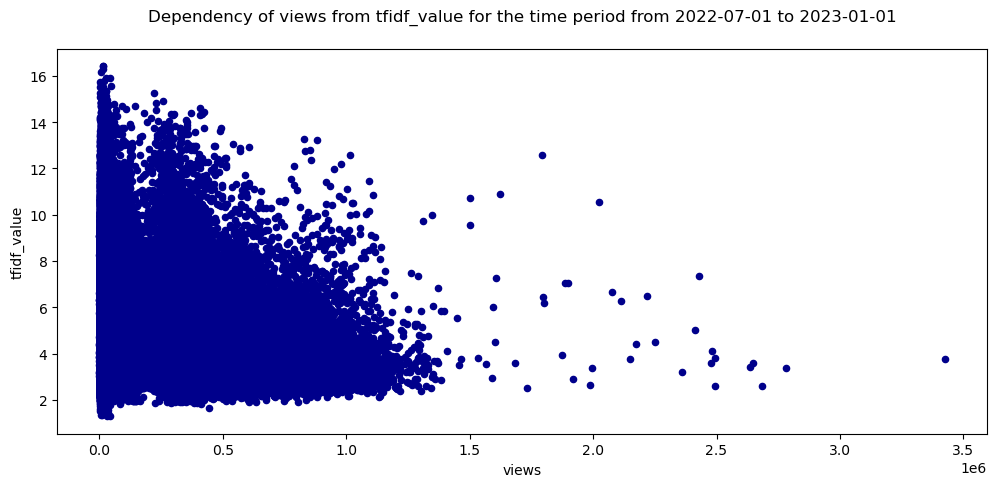

In [274]:
df[['views', 'tfidf_value']].plot.scatter(x='views',
                      y='tfidf_value',
                      c='DarkBlue')

plt.title('Dependency of views from tfidf_value for the time period from 2022-07-01 to 2023-01-01',y=1.05)
plt.show()

### Posts with the most views

In [275]:
print(df[df['views'] == df['views'].max()]['message'].to_list()[0])

⚡️Завтра в 15.00 в Кремле пройдет церемония подписания договоров о вступлении в состав России новых территорий.

По словам Пескова, договоры будут подписаны со всеми 4 территориями, где прошли референдумы. Будет объемное выступление Путина.


### The most important messages

In [276]:
print(df.iloc[0]['message'])

ПОВЕСТКА ДНЯ 22.07.22

от телеграм-агентства Телестрим

ИА REGNUM о 20-летинем юбилее первой в России независимой федеральной платформы:
«…ИА REGNUM стало первой в России независимой федеральной платформой для новостей из регионов страны, а затем соединило их с новостями центра, затем — с новостями из стран ближнего зарубежья, затем — с новостями всего мир…»

Движение Сорок Сороков о том, кто следующий в очереди на неоконовскую утилизацию: 
«…До поляков начинает доходить, что вслед за дубиноголовыми укропитеками следующим пушечным мясом в столкновении Российской Империи с СССР 2.0 неоконов станут они…»

Ольга Кормухина об отписках на телеграм-каналах соратников:
«…Я уже недели три обращаю на это внимание. У всех- спад. В то время, как у сомнительных или явно проплаченных ресурсов- всё растёт огромными темпами! Недаром же тут в телеге обсуждалось, что идёт скупка каналов целыми сетками…»

Железный Феликс о новой тактике оппов на предстоящих выборах:
«…Теперь они пытаются пропихнуть во в

In [278]:
print(df.iloc[2]['message'])

ПОВЕСТКА ДНЯ 02.08.22

от телеграм-агентства Телестрим 

Тот самый Олень о каникулах на Донбассе:
«Каникулы» наши прошли в очень необычном месте, да и вряд ли это можно назвать отпуском – провели мы это время в активной работе «на земле» на Донбассе, успев глубоко погрузится в местную конъюнктуру и проблематику…»

Елена Панина о том, что Америка при Байдене и Пелоси превратилась в страну-гопника:
"Ну и куда она двинется дальше: на Тайвань или домой? — прямо сейчас гадают аналитики всего мира, наблюдая за лобовой атакой Нэнси Пелоси на Китай. — Бабушка старая, ей все равно"

Железный Феликс о проверке Следкома в отношении блогера Евгения Савина.
"Еще одним выявленным пособником укронацистов больше. И такие уголовные дела надо возбуждать в отношении всех, проявляющих русофобию"

REDACTED P6 (КОТËЛ #6) о том, как Арктика топит Росприроднадзор. 
«…По всем признакам, «Центр «Арктические инициативы»  – типичная отмывочная контора по превращению в интересах Росприроднадзора денег в частные до

In [308]:
# watchlist
data_list = [watchlist_0, watchlist_1, watchlist_2, watchlist_3, watchlist_4, watchlist_5, watchlist_6, watchlist_7, 
             watchlist_8, watchlist_9, watchlist_10, watchlist_11, watchlist_12, watchlist_13]

In [309]:
watchlist_df = pd.DataFrame.from_records(data_list, columns=watchlist, index = [el[1] for el in periods_list_2])

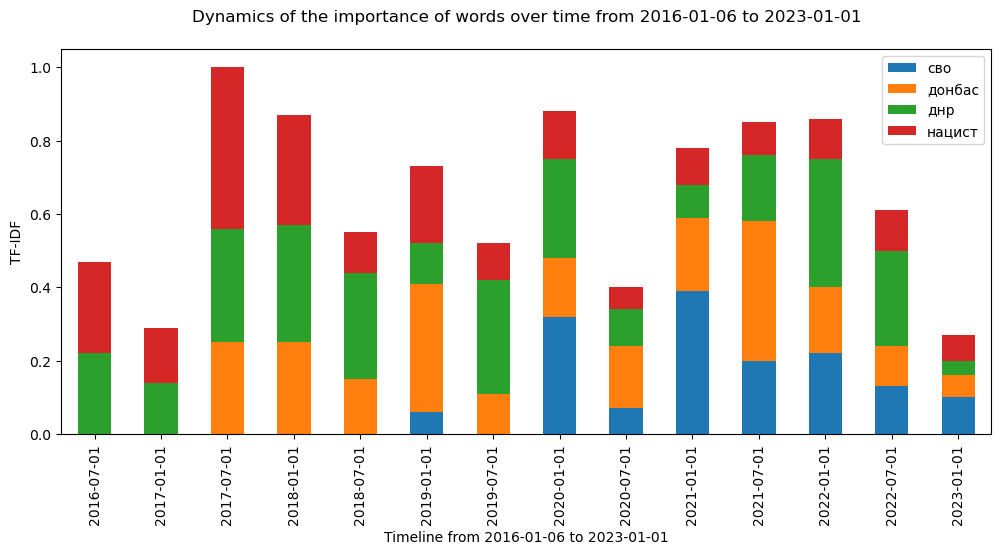

In [311]:
watchlist_df[['сво', 'донбас', 'днр', 'нацист']].plot(kind='bar', stacked=True)
# ax = plt.axes() 
# ax.set_xticks([el[1] for el in periods_list_2])
plt.xlabel('Timeline from 2016-01-06 to 2023-01-01')
plt.ylabel('TF-IDF')
plt.title('Dynamics of the importance of words over time from 2016-01-06 to 2023-01-01',y=1.05)
plt.show()

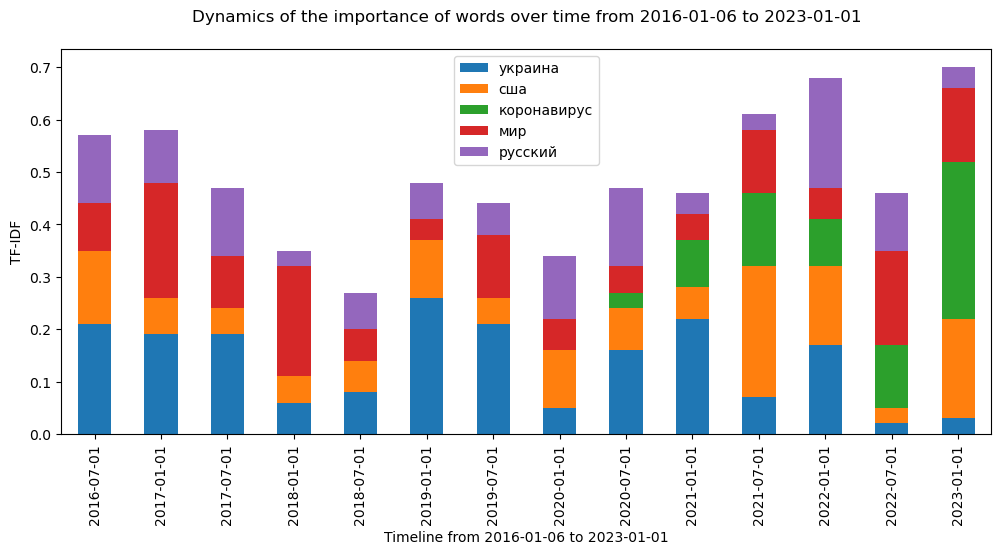

In [326]:
watchlist_df[['украина', 'сша', 'коронавирус', 'мир', 'русский']].plot(kind='bar', stacked=True)
# ax = plt.axes() 
# ax.set_xticks([el[1] for el in periods_list_2])
plt.xlabel('Timeline from 2016-01-06 to 2023-01-01')
plt.ylabel('TF-IDF')
plt.title('Dynamics of the importance of words over time from 2016-01-06 to 2023-01-01',y=1.05)
plt.show()

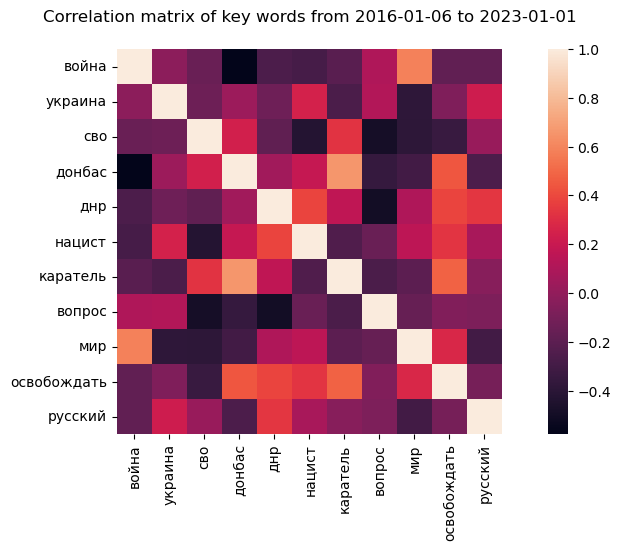

In [327]:
corr = watchlist_df[['война', 'украина', 'сво', 'донбас', 'днр', 'нацист', 'каратель', 'вопрос', 'мир', 'освобождать', 'русский']].corr()
labels =  np.array(corr)
fig, ax = plt.subplots()
ax = sns.heatmap(corr, fmt = '', square=True)
plt.title('Correlation matrix of key words from 2016-01-06 to 2023-01-01',y=1.05)
plt.show()